#MODELS

## LARGE MODELS

### UNet WITH 4 UPSAMPLING LAYERS

In [1]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
import copy
from torchsummary import summary
import time


In [2]:
class Double3DConvVBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bottleneck=False, befBottleneck=False) -> None:
        super(Double3DConvVBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels//2, kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(num_features=out_channels//2),
            nn.ReLU(inplace=True),
            nn.Conv3d(in_channels=out_channels//2, out_channels=out_channels, kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU(inplace=True),
        )
        self.bottleneck = bottleneck
        if not bottleneck:
            self.pooling = nn.MaxPool3d(kernel_size=(2,2,2), stride=2) if not befBottleneck else nn.MaxPool3d(kernel_size=(2,2,1), stride=(2,2,1))

    def forward(self, x):
        res = self.conv(x)
        out = res
        if not self.bottleneck:
            out = self.pooling(res)
        return out, res

class UpConv3DBlock(nn.Module):
    def __init__(self, in_channels, res_channels=0, last_layer=False, num_classes=None) -> None:
        super(UpConv3DBlock, self).__init__()
        assert (last_layer == False and num_classes == None) or (last_layer == True and num_classes != None), 'Invalid arguments'
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels=in_channels + res_channels, out_channels=in_channels // 2, kernel_size=(3,3,3), padding=(1,1,1)),
            nn.BatchNorm3d(num_features=in_channels // 2),
            nn.ReLU(inplace=True),
            nn.Conv3d(in_channels=in_channels // 2, out_channels=in_channels // 2, kernel_size=(3,3,3), padding=(1,1,1)),
            nn.BatchNorm3d(num_features=in_channels // 2),
            nn.ReLU(inplace=True),
        )
        self.last_layer = last_layer
        if last_layer:
            self.conv3 = nn.Conv3d(in_channels=in_channels // 2, out_channels=num_classes, kernel_size=(1,1,1))

    def forward(self, x, residual=None):
        if residual is not None:
            # Upsample to match the residual's spatial dimensions
            x = F.interpolate(x, size=residual.shape[2:], mode='trilinear', align_corners=False)
            x = torch.cat((x, residual), 1)
        else:
            # For the final layer, we only upsample
            x = F.interpolate(x, scale_factor=(2, 2, 1) if self.last_layer else (2, 2, 2), mode='trilinear', align_corners=False)

        x = self.conv(x)
        if self.last_layer:
            x = self.conv3(x)
        return x

class UNET3D(nn.Module):
    def __init__(self, in_channels, num_classes, level_channels=[32, 64, 128, 256], bottleneck_channel=512) -> None:
        super(UNET3D, self).__init__()
        level_1_chnls, level_2_chnls, level_3_chnls, level_4_chnls = level_channels[0], level_channels[1], level_channels[2], level_channels[3]
        self.a_block1 = Double3DConvVBlock(in_channels=in_channels, out_channels=level_1_chnls)
        self.a_block2 = Double3DConvVBlock(in_channels=level_1_chnls, out_channels=level_2_chnls)
        self.a_block3 = Double3DConvVBlock(in_channels=level_2_chnls, out_channels=level_3_chnls)
        self.a_block4 = Double3DConvVBlock(in_channels=level_3_chnls, out_channels=level_4_chnls)
        self.bottleNeck = Double3DConvVBlock(in_channels=level_4_chnls, out_channels=bottleneck_channel, bottleneck=True)
        self.s_block4 = UpConv3DBlock(in_channels=bottleneck_channel, res_channels=level_4_chnls)
        self.s_block3 = UpConv3DBlock(in_channels=level_4_chnls, res_channels=level_3_chnls)
        self.s_block2 = UpConv3DBlock(in_channels=level_3_chnls, res_channels=level_2_chnls)
        self.s_block1 = UpConv3DBlock(in_channels=level_2_chnls, res_channels=level_1_chnls, last_layer=True, num_classes=num_classes)

    def pad_input(self, x):
        # Pad the input tensor to ensure even dimensions for depth
        d_padding = (x.shape[2] % 2, 0) # pad only if the depth is odd
        return F.pad(x, d_padding + (0, 0) + (0, 0)) # pad depth, height, width
    '''
    def pad_input(self, x):
        # Get the depth, height, and width from the input tensor
        depth = x.shape[-1]   # depth is the third-last dimension
        height = x.shape[-3]  # height is the second-last dimension
        width = x.shape[-2]   # width is the last dimension

        # Determine the padding for each dimension (only pad if dimensions are odd)
        d_padding = (1, 0) if depth % 2 != 0 else (0, 0)
        h_padding = (1, 0) if height % 2 != 0 else (0, 0)
        w_padding = (1, 0) if width % 2 != 0 else (0, 0)

        # Apply padding in the correct order (depth, height, width)
        padding = (h_padding, w_padding, d_padding)

        return F.pad(x, padding)
    '''

    def forward(self, input):
        #print(input.shape)
        #input = self.pad_input(input)

        # Analysis path forward feed
        out, residual_level1 = self.a_block1(input)
        out, residual_level2 = self.a_block2(out)
        out, residual_level3 = self.a_block3(out)
        out, residual_level4 = self.a_block4(out)
        out, _ = self.bottleNeck(out)

        # Synthesis path forward feed
        out = self.s_block4(out, residual_level4)
        out = self.s_block3(out, residual_level3)
        out = self.s_block2(out, residual_level2)
        out = self.s_block1(out, residual_level1)

        # Apply softmax to output if the model is in eval mode
        if not self.training:
            out = F.softmax(out, dim=1)
        return out


### ATTENTION UNet

In [3]:
class DoubleConvSame3D(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(DoubleConvSame3D, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(
                in_channels=in_channels, out_channels=num_classes, kernel_size=3, stride=1, padding=1
            ),
            nn.ReLU(inplace=True),
            nn.Conv3d(
                in_channels=num_classes,
                out_channels=num_classes,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class Encoder3D(nn.Module):
    def __init__(self, in_channels):
        super(Encoder3D, self).__init__()

        self.conv = DoubleConvSame3D(in_channels=in_channels, num_classes=in_channels * 2)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

    def forward(self, x):
        c = self.conv(x)
        p = self.pool(c)

        return c, p

In [4]:
#conv, relu, conv, relu, up(doubling its spatial dimensions and reducing the number of channels by half)
class AttentionDecoder3D(nn.Module):
    def __init__(self, in_channels):
        super(AttentionDecoder3D, self).__init__()

        self.up_conv = DoubleConvSame3D(in_channels=in_channels, num_classes=in_channels // 2)
        self.up = nn.ConvTranspose3d(
            in_channels=in_channels,
            out_channels=in_channels // 2,
            kernel_size=2,
            stride=2,
        )

    def forward(self, conv1, conv2, attn):
        up = self.up(conv1)
        mult = torch.multiply(attn, up)
        cat = torch.cat([mult, conv2], dim=1)
        uc = self.up_conv(cat)

        return uc


In [5]:
class AttentionBlock3D(nn.Module):
    """
    Class for creating Attention module
    Takes in gating signal `g` and `x`
    """

    def __init__(self, g_chl, x_chl):
        super(AttentionBlock3D, self).__init__()

        inter_shape = x_chl // 4

        # Conv 1x1 with stride 2 for `x`
        self.conv_x = nn.Conv3d(
            in_channels=x_chl,
            out_channels=inter_shape,
            kernel_size=1,
            stride=2,
        )

        # Conv 1x1 with stride 1 for `g` (gating signal)
        self.conv_g = nn.Conv3d(
            in_channels=g_chl,
            out_channels=inter_shape,
            kernel_size=1,
            stride=1,
        )

        # Conv 1x1 for `psi` the output after `g` + `x`
        self.psi = nn.Conv3d(
            in_channels=2 * inter_shape,
            out_channels=1,
            kernel_size=1,
            stride=1,
        )

        # For upsampling the attention output to size of `x`
        self.upsample = nn.Upsample(scale_factor=2)

    def forward(self, g, x):

        # perform the convs on `x` and `g`
        theta_x = self.conv_x(x)
        gate = self.conv_g(g)

        # `theta_x` + `gate`
        add = torch.cat([gate, theta_x], dim=1)

        # ReLU on the add operation
        relu = torch.relu(add)

        # the 1x1 Conv
        psi = self.psi(relu)

        # Sigmoid the squash the outputs/attention weights
        sig = torch.sigmoid(psi)

        # Upsample to original size of `x` to perform multiplication
        upsample = self.upsample(sig)

        # return the attention weights!
        return upsample


class AUNET3D(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(AUNET3D, self).__init__()

        self.conv1 = DoubleConvSame3D(in_channels=in_channels, num_classes=64)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        self.enc1 = Encoder3D(64)
        self.enc2 = Encoder3D(128)
        self.enc3 = Encoder3D(256)
        self.enc4 = Encoder3D(512)

        self.conv5 = DoubleConvSame3D(in_channels=512, num_classes=1024)

        self.attn1 = AttentionBlock3D(1024, 512)
        self.attn2 = AttentionBlock3D(512, 256)
        self.attn3 = AttentionBlock3D(256, 128)
        self.attn4 = AttentionBlock3D(128, 64)

        self.attndeco1 = AttentionDecoder3D(1024)
        self.attndeco2 = AttentionDecoder3D(512)
        self.attndeco3 = AttentionDecoder3D(256)
        self.attndeco4 = AttentionDecoder3D(128)

        self.conv_1x1 = nn.Conv3d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        """ENCODER"""

        c1 = self.conv1(x)
        p1 = self.pool(c1)

        c2, p2 = self.enc1(p1)
        c3, p3 = self.enc2(p2)
        c4, p4 = self.enc3(p3)

        """BOTTLE-NECK"""

        c5 = self.conv5(p4)

        """DECODER - WITH ATTENTION"""

        att1 = self.attn1(c5, c4)
        uc1 = self.attndeco1(c5, c4, att1)

        att2 = self.attn2(uc1, c3)
        uc2 = self.attndeco2(c4, c3, att2)

        att3 = self.attn3(uc2, c2)
        uc3 = self.attndeco3(c3, c2, att3)

        att4 = self.attn4(uc3, c1)
        uc4 = self.attndeco4(c2, c1, att4)

        outputs = self.conv_1x1(uc4)

        return outputs

### SOFTMAX ATTENTION-UNET  

In [6]:
class AUNET3DSOFTMAX(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(AUNET3D, self).__init__()

        self.conv1 = DoubleConvSame3D(in_channels=in_channels, num_classes=64)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        self.enc1 = Encoder3D(64)
        self.enc2 = Encoder3D(128)
        self.enc3 = Encoder3D(256)
        self.enc4 = Encoder3D(512)

        self.conv5 = DoubleConvSame3D(in_channels=512, num_classes=1024)

        self.attn1 = AttentionBlock3D(1024, 512)
        self.attn2 = AttentionBlock3D(512, 256)
        self.attn3 = AttentionBlock3D(256, 128)
        self.attn4 = AttentionBlock3D(128, 64)

        self.attndeco1 = AttentionDecoder3D(1024)
        self.attndeco2 = AttentionDecoder3D(512)
        self.attndeco3 = AttentionDecoder3D(256)
        self.attndeco4 = AttentionDecoder3D(128)

        self.conv_1x1 = nn.Conv3d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        """ENCODER"""

        c1 = self.conv1(x)
        p1 = self.pool(c1)

        c2, p2 = self.enc1(p1)
        c3, p3 = self.enc2(p2)
        c4, p4 = self.enc3(p3)

        """BOTTLE-NECK"""

        c5 = self.conv5(p4)

        """DECODER - WITH ATTENTION"""

        att1 = self.attn1(c5, c4)
        uc1 = self.attndeco1(c5, c4, att1)

        att2 = self.attn2(uc1, c3)
        uc2 = self.attndeco2(c4, c3, att2)

        att3 = self.attn3(uc2, c2)
        uc3 = self.attndeco3(c3, c2, att3)

        att4 = self.attn4(uc3, c1)
        uc4 = self.attndeco4(c2, c1, att4)

        outputs = self.conv_1x1(uc4)

        # Apply softmax to output if the model is in eval mode
        if not self.training:
            outputs = F.softmax(outputs, dim=1)

        return outputs

### UNetR TRANSFORMER

In [7]:
class SingleDeconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super().__init__()
        self.block = nn.ConvTranspose3d(in_planes, out_planes, kernel_size=2, stride=2, padding=0, output_padding=0)

    def forward(self, x):
        return self.block(x)


class SingleConv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super().__init__()
        self.block = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=1,
                               padding=((kernel_size - 1) // 2))

    def forward(self, x):
        return self.block(x)


class Conv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleConv3DBlock(in_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)


class Deconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleDeconv3DBlock(in_planes, out_planes),
            SingleConv3DBlock(out_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)


class SelfAttention(nn.Module):
    def __init__(self, num_heads, embed_dim, dropout):
        super().__init__()
        self.num_attention_heads = num_heads
        self.attention_head_size = int(embed_dim / num_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(embed_dim, self.all_head_size)
        self.key = nn.Linear(embed_dim, self.all_head_size)
        self.value = nn.Linear(embed_dim, self.all_head_size)

        self.out = nn.Linear(embed_dim, embed_dim)
        self.attn_dropout = nn.Dropout(dropout)
        self.proj_dropout = nn.Dropout(dropout)

        self.softmax = nn.Softmax(dim=-1)

        self.vis = False

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs if self.vis else None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights


class Mlp(nn.Module):
    def __init__(self, in_features, act_layer=nn.GELU, drop=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, in_features)
        self.act = act_layer()
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1()
        x = self.act(x)
        x = self.drop(x)
        return x


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model=786, d_ff=2048, dropout=0.1):
        super().__init__()
        # Torch linears have a `b` by default.
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


class Embeddings(nn.Module):
    def __init__(self, input_dim, embed_dim, cube_size, patch_size, dropout):
        super().__init__()
        self.n_patches = int((cube_size[0] * cube_size[1] * cube_size[2]) / (patch_size * patch_size * patch_size))
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.patch_embeddings = nn.Conv3d(in_channels=input_dim, out_channels=embed_dim,
                                          kernel_size=patch_size, stride=patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, self.n_patches, embed_dim))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.patch_embeddings(x)
        x = x.flatten(2)
        x = x.transpose(-1, -2)
        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings


class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout, cube_size, patch_size):
        super().__init__()
        self.attention_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp_dim = int((cube_size[0] * cube_size[1] * cube_size[2]) / (patch_size * patch_size * patch_size))
        self.mlp = PositionwiseFeedForward(embed_dim, 2048)
        self.attn = SelfAttention(num_heads, embed_dim, dropout)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
        x = x + h
        h = x

        x = self.mlp_norm(x)
        x = self.mlp(x)

        x = x + h
        return x, weights


class Transformer(nn.Module):
    def __init__(self, input_dim, embed_dim, cube_size, patch_size, num_heads, num_layers, dropout, extract_layers):
        super().__init__()
        self.embeddings = Embeddings(input_dim, embed_dim, cube_size, patch_size, dropout)
        self.layer = nn.ModuleList()
        self.encoder_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.extract_layers = extract_layers
        for _ in range(num_layers):
            layer = TransformerBlock(embed_dim, num_heads, dropout, cube_size, patch_size)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, x):
        extract_layers = []
        hidden_states = self.embeddings(x)

        for depth, layer_block in enumerate(self.layer):
            hidden_states, _ = layer_block(hidden_states)
            if depth + 1 in self.extract_layers:
                extract_layers.append(hidden_states)

        return extract_layers

class UNETR(nn.Module):
    def __init__(self, img_shape=(64, 64, 64), input_dim=1, output_dim=4, embed_dim=768, patch_size=8, num_heads=12, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embed_dim = embed_dim
        self.img_shape = img_shape
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.num_layers = 12
        self.ext_layers = [3, 6, 9, 12]

        self.patch_dim = [int(x / patch_size) for x in img_shape]

        # Transformer Encoder
        self.transformer = Transformer(
            input_dim,
            embed_dim,
            img_shape,
            patch_size,
            num_heads,
            self.num_layers,
            dropout,
            self.ext_layers
        )

        # U-Net Decoder
        self.decoder0 = nn.Sequential(
            Conv3DBlock(input_dim, 32, 3),
            Conv3DBlock(32, 64, 3)
        )

        self.decoder3 = nn.Sequential(
            Deconv3DBlock(embed_dim, 512),
            Deconv3DBlock(512, 256),
            Deconv3DBlock(256, 128)
        )

        self.decoder6 = nn.Sequential(
            Deconv3DBlock(embed_dim, 512),
            Deconv3DBlock(512, 256),
        )

        self.decoder9 = Deconv3DBlock(embed_dim, 512)

        self.decoder12_upsampler = SingleDeconv3DBlock(embed_dim, 512)

        self.decoder9_upsampler = nn.Sequential(
            Conv3DBlock(1024, 512),
            Conv3DBlock(512, 512),
            Conv3DBlock(512, 512),
            SingleDeconv3DBlock(512, 256)
        )

        self.decoder6_upsampler = nn.Sequential(
            Conv3DBlock(512, 256),
            Conv3DBlock(256, 256),
            SingleDeconv3DBlock(256, 128)
        )

        self.decoder3_upsampler = nn.Sequential(
            Conv3DBlock(256, 128),
            Conv3DBlock(128, 128),
            SingleDeconv3DBlock(128, 64),
            nn.MaxPool3d(kernel_size=2, stride=2)

        )

        self.decoder0_header = nn.Sequential(
            Conv3DBlock(128, 64),
            Conv3DBlock(64, 64),
            SingleConv3DBlock(64, output_dim, 1)
        )

    def forward(self, x):
        z = self.transformer(x)
        z0, z3, z6, z9, z12 = x, *z

        # Reshape and print shapes
        z3 = z3.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z6 = z6.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z9 = z9.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z12 = z12.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)

        z12 = self.decoder12_upsampler(z12)

        z9 = self.decoder9(z9)
        z9 = self.decoder9_upsampler(torch.cat([z9, z12], dim=1))

        z6 = self.decoder6(z6)
        z6 = self.decoder6_upsampler(torch.cat([z6, z9], dim=1))

        z3 = self.decoder3(z3)
        z3 = self.decoder3_upsampler(torch.cat([z3, z6], dim=1))

        z0 = self.decoder0(z0)
        output = self.decoder0_header(torch.cat([z0, z3], dim=1))
        return output


### UNetR TRANSFORMER SOFTMAX

In [8]:
class SingleDeconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super().__init__()
        self.block = nn.ConvTranspose3d(in_planes, out_planes, kernel_size=2, stride=2, padding=0, output_padding=0)

    def forward(self, x):
        return self.block(x)


class SingleConv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super().__init__()
        self.block = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=1,
                               padding=((kernel_size - 1) // 2))

    def forward(self, x):
        return self.block(x)


class Conv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleConv3DBlock(in_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)


class Deconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleDeconv3DBlock(in_planes, out_planes),
            SingleConv3DBlock(out_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)


class SelfAttention(nn.Module):
    def __init__(self, num_heads, embed_dim, dropout):
        super().__init__()
        self.num_attention_heads = num_heads
        self.attention_head_size = int(embed_dim / num_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(embed_dim, self.all_head_size)
        self.key = nn.Linear(embed_dim, self.all_head_size)
        self.value = nn.Linear(embed_dim, self.all_head_size)

        self.out = nn.Linear(embed_dim, embed_dim)
        self.attn_dropout = nn.Dropout(dropout)
        self.proj_dropout = nn.Dropout(dropout)

        self.softmax = nn.Softmax(dim=-1)

        self.vis = False

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs if self.vis else None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights


class Mlp(nn.Module):
    def __init__(self, in_features, act_layer=nn.GELU, drop=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, in_features)
        self.act = act_layer()
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1()
        x = self.act(x)
        x = self.drop(x)
        return x


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model=786, d_ff=2048, dropout=0.1):
        super().__init__()
        # Torch linears have a `b` by default.
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


class Embeddings(nn.Module):
    def __init__(self, input_dim, embed_dim, cube_size, patch_size, dropout):
        super().__init__()
        self.n_patches = int((cube_size[0] * cube_size[1] * cube_size[2]) / (patch_size * patch_size * patch_size))
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.patch_embeddings = nn.Conv3d(in_channels=input_dim, out_channels=embed_dim,
                                          kernel_size=patch_size, stride=patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, self.n_patches, embed_dim))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.patch_embeddings(x)
        x = x.flatten(2)
        x = x.transpose(-1, -2)
        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings


class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout, cube_size, patch_size):
        super().__init__()
        self.attention_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp_dim = int((cube_size[0] * cube_size[1] * cube_size[2]) / (patch_size * patch_size * patch_size))
        self.mlp = PositionwiseFeedForward(embed_dim, 2048)
        self.attn = SelfAttention(num_heads, embed_dim, dropout)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
        x = x + h
        h = x

        x = self.mlp_norm(x)
        x = self.mlp(x)

        x = x + h
        return x, weights


class Transformer(nn.Module):
    def __init__(self, input_dim, embed_dim, cube_size, patch_size, num_heads, num_layers, dropout, extract_layers):
        super().__init__()
        self.embeddings = Embeddings(input_dim, embed_dim, cube_size, patch_size, dropout)
        self.layer = nn.ModuleList()
        self.encoder_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.extract_layers = extract_layers
        for _ in range(num_layers):
            layer = TransformerBlock(embed_dim, num_heads, dropout, cube_size, patch_size)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, x):
        extract_layers = []
        hidden_states = self.embeddings(x)

        for depth, layer_block in enumerate(self.layer):
            hidden_states, _ = layer_block(hidden_states)
            if depth + 1 in self.extract_layers:
                extract_layers.append(hidden_states)

        return extract_layers

class UNETRSOFTMAX(nn.Module):
    def __init__(self, img_shape=(64, 64, 64), input_dim=1, output_dim=4, embed_dim=768, patch_size=8, num_heads=12, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embed_dim = embed_dim
        self.img_shape = img_shape
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.num_layers = 12
        self.ext_layers = [3, 6, 9, 12]

        self.patch_dim = [int(x / patch_size) for x in img_shape]

        # Transformer Encoder
        self.transformer = Transformer(
            input_dim,
            embed_dim,
            img_shape,
            patch_size,
            num_heads,
            self.num_layers,
            dropout,
            self.ext_layers
        )

        # U-Net Decoder
        self.decoder0 = nn.Sequential(
            Conv3DBlock(input_dim, 32, 3),
            Conv3DBlock(32, 64, 3)
        )

        self.decoder3 = nn.Sequential(
            Deconv3DBlock(embed_dim, 512),
            Deconv3DBlock(512, 256),
            Deconv3DBlock(256, 128)
        )

        self.decoder6 = nn.Sequential(
            Deconv3DBlock(embed_dim, 512),
            Deconv3DBlock(512, 256),
        )

        self.decoder9 = Deconv3DBlock(embed_dim, 512)

        self.decoder12_upsampler = SingleDeconv3DBlock(embed_dim, 512)

        self.decoder9_upsampler = nn.Sequential(
            Conv3DBlock(1024, 512),
            Conv3DBlock(512, 512),
            Conv3DBlock(512, 512),
            SingleDeconv3DBlock(512, 256)
        )

        self.decoder6_upsampler = nn.Sequential(
            Conv3DBlock(512, 256),
            Conv3DBlock(256, 256),
            SingleDeconv3DBlock(256, 128)
        )

        self.decoder3_upsampler = nn.Sequential(
            Conv3DBlock(256, 128),
            Conv3DBlock(128, 128),
            SingleDeconv3DBlock(128, 64),
            nn.MaxPool3d(kernel_size=2, stride=2)

        )

        self.decoder0_header = nn.Sequential(
            Conv3DBlock(128, 64),
            Conv3DBlock(64, 64),
            SingleConv3DBlock(64, output_dim, 1)
        )

    def forward(self, x):
        z = self.transformer(x)
        z0, z3, z6, z9, z12 = x, *z

        # Reshape and print shapes
        z3 = z3.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z6 = z6.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z9 = z9.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z12 = z12.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)

        z12 = self.decoder12_upsampler(z12)

        z9 = self.decoder9(z9)
        z9 = self.decoder9_upsampler(torch.cat([z9, z12], dim=1))

        z6 = self.decoder6(z6)
        z6 = self.decoder6_upsampler(torch.cat([z6, z9], dim=1))

        z3 = self.decoder3(z3)
        z3 = self.decoder3_upsampler(torch.cat([z3, z6], dim=1))

        z0 = self.decoder0(z0)
        output = self.decoder0_header(torch.cat([z0, z3], dim=1))
        # Apply softmax to output if the model is in eval mode
        if not self.training:
            output = F.softmax(output, dim=1)

        return output


## SMALL MODELS

### SMALL UNET
(with 3 Layers and Reduced Hyperparameters)
This small version reduces the depth by removing the last downsampling and upsampling layers (i.e., 3 layers instead of 4). The number of channels is also reduced to make the model lighter.

In [9]:
class SmallUNET3D(nn.Module):
    def __init__(self, in_channels, num_classes, level_channels=[16, 32, 64], bottleneck_channel=128) -> None:
        super(SmallUNET3D, self).__init__()
        level_1_chnls, level_2_chnls, level_3_chnls = level_channels[0], level_channels[1], level_channels[2]
        self.a_block1 = Double3DConvVBlock(in_channels=in_channels, out_channels=level_1_chnls)
        self.a_block2 = Double3DConvVBlock(in_channels=level_1_chnls, out_channels=level_2_chnls)
        self.a_block3 = Double3DConvVBlock(in_channels=level_2_chnls, out_channels=level_3_chnls)
        self.bottleNeck = Double3DConvVBlock(in_channels=level_3_chnls, out_channels=bottleneck_channel, bottleneck=True)
        self.s_block3 = UpConv3DBlock(in_channels=bottleneck_channel, res_channels=level_3_chnls)
        self.s_block2 = UpConv3DBlock(in_channels=level_3_chnls, res_channels=level_2_chnls)
        self.s_block1 = UpConv3DBlock(in_channels=level_2_chnls, res_channels=level_1_chnls, last_layer=True, num_classes=num_classes)

    def pad_input(self, x):
        d_padding = (x.shape[2] % 2, 0)
        return F.pad(x, d_padding + (0, 0) + (0, 0))

    def forward(self, input):
        input = self.pad_input(input)

        # Analysis path
        out, residual_level1 = self.a_block1(input)
        out, residual_level2 = self.a_block2(out)
        out, residual_level3 = self.a_block3(out)
        out, _ = self.bottleNeck(out)

        # Synthesis path
        out = self.s_block3(out, residual_level3)
        out = self.s_block2(out, residual_level2)
        out = self.s_block1(out, residual_level1)

        if not self.training:
            out = F.softmax(out, dim=1)
        return out


### SMALL ATTENTION UNET

(3 Layers, Reduced Hyperparameters)
In this small version, the architecture is reduced to 3 encoding and decoding layers, while also reducing the number of channels at each stage.

In [10]:
class DoubleConvSame3D(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(DoubleConvSame3D, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(
                in_channels=in_channels, out_channels=num_classes, kernel_size=3, stride=1, padding=1
            ),
            nn.ReLU(inplace=True),
            nn.Conv3d(
                in_channels=num_classes,
                out_channels=num_classes,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class Encoder3D(nn.Module):
    def __init__(self, in_channels):
        super(Encoder3D, self).__init__()

        self.conv = DoubleConvSame3D(in_channels=in_channels, num_classes=in_channels * 2)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

    def forward(self, x):
        c = self.conv(x)
        p = self.pool(c)

        return c, p

#conv, relu, conv, relu, up(doubling its spatial dimensions and reducing the number of channels by half)
class AttentionDecoder3D(nn.Module):
    def __init__(self, in_channels):
        super(AttentionDecoder3D, self).__init__()

        self.up_conv = DoubleConvSame3D(in_channels=in_channels, num_classes=in_channels // 2)
        self.up = nn.ConvTranspose3d(
            in_channels=in_channels,
            out_channels=in_channels // 2,
            kernel_size=2,
            stride=2,
        )

    def forward(self, conv1, conv2, attn):
        up = self.up(conv1)
        mult = torch.multiply(attn, up)
        cat = torch.cat([mult, conv2], dim=1)
        uc = self.up_conv(cat)

        return uc

class AttentionBlock3D(nn.Module):
    """
    Class for creating Attention module
    Takes in gating signal `g` and `x`
    """

    def __init__(self, g_chl, x_chl):
        super(AttentionBlock3D, self).__init__()

        inter_shape = x_chl // 4

        # Conv 1x1 with stride 2 for `x`
        self.conv_x = nn.Conv3d(
            in_channels=x_chl,
            out_channels=inter_shape,
            kernel_size=1,
            stride=2,
        )

        # Conv 1x1 with stride 1 for `g` (gating signal)
        self.conv_g = nn.Conv3d(
            in_channels=g_chl,
            out_channels=inter_shape,
            kernel_size=1,
            stride=1,
        )

        # Conv 1x1 for `psi` the output after `g` + `x`
        self.psi = nn.Conv3d(
            in_channels=2 * inter_shape,
            out_channels=1,
            kernel_size=1,
            stride=1,
        )

        # For upsampling the attention output to size of `x`
        self.upsample = nn.Upsample(scale_factor=2)

    def forward(self, g, x):

        # perform the convs on `x` and `g`
        theta_x = self.conv_x(x)
        gate = self.conv_g(g)

        # `theta_x` + `gate`
        add = torch.cat([gate, theta_x], dim=1)

        # ReLU on the add operation
        relu = torch.relu(add)

        # the 1x1 Conv
        psi = self.psi(relu)

        # Sigmoid the squash the outputs/attention weights
        sig = torch.sigmoid(psi)

        # Upsample to original size of `x` to perform multiplication
        upsample = self.upsample(sig)

        # return the attention weights!
        return upsample


class AUNET3D(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(AUNET3D, self).__init__()

        self.conv1 = DoubleConvSame3D(in_channels=in_channels, num_classes=64)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        self.enc1 = Encoder3D(64)
        self.enc2 = Encoder3D(128)
        self.enc3 = Encoder3D(256)
        self.enc4 = Encoder3D(512)

        self.conv5 = DoubleConvSame3D(in_channels=512, num_classes=1024)

        self.attn1 = AttentionBlock3D(1024, 512)
        self.attn2 = AttentionBlock3D(512, 256)
        self.attn3 = AttentionBlock3D(256, 128)
        self.attn4 = AttentionBlock3D(128, 64)

        self.attndeco1 = AttentionDecoder3D(1024)
        self.attndeco2 = AttentionDecoder3D(512)
        self.attndeco3 = AttentionDecoder3D(256)
        self.attndeco4 = AttentionDecoder3D(128)

        self.conv_1x1 = nn.Conv3d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        """ENCODER"""

        c1 = self.conv1(x)
        p1 = self.pool(c1)

        c2, p2 = self.enc1(p1)
        c3, p3 = self.enc2(p2)
        c4, p4 = self.enc3(p3)

        """BOTTLE-NECK"""

        c5 = self.conv5(p4)

        """DECODER - WITH ATTENTION"""

        att1 = self.attn1(c5, c4)
        uc1 = self.attndeco1(c5, c4, att1)

        att2 = self.attn2(uc1, c3)
        uc2 = self.attndeco2(c4, c3, att2)

        att3 = self.attn3(uc2, c2)
        uc3 = self.attndeco3(c3, c2, att3)

        att4 = self.attn4(uc3, c1)
        uc4 = self.attndeco4(c2, c1, att4)

        outputs = self.conv_1x1(uc4)

        return outputs

In [11]:
class SmallAUNET3D(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SmallAUNET3D, self).__init__()

        self.conv1 = DoubleConvSame3D(in_channels=in_channels, num_classes=32)  # Reduced channel size
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        self.enc1 = Encoder3D(32)
        self.enc2 = Encoder3D(64)
        self.enc3 = Encoder3D(128)

        self.conv4 = DoubleConvSame3D(in_channels=128, num_classes=256)  # Removed deeper layers

        self.attn1 = AttentionBlock3D(256, 128)
        self.attn2 = AttentionBlock3D(128, 64)
        self.attn3 = AttentionBlock3D(64, 32)

        self.attndeco1 = AttentionDecoder3D(256)
        self.attndeco2 = AttentionDecoder3D(128)
        self.attndeco3 = AttentionDecoder3D(64)

        self.conv_1x1 = nn.Conv3d(in_channels=32, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        """ENCODER"""
        c1 = self.conv1(x)
        p1 = self.pool(c1)

        c2, p2 = self.enc1(p1)
        c3, p3 = self.enc2(p2)

        """BOTTLE-NECK"""
        c4 = self.conv4(p3)

        """DECODER - WITH ATTENTION"""
        att1 = self.attn1(c4, c3)
        uc1 = self.attndeco1(c4, c3, att1)

        att2 = self.attn2(uc1, c2)
        uc2 = self.attndeco2(uc1, c2, att2)

        att3 = self.attn3(uc2, c1)
        uc3 = self.attndeco3(uc2, c1, att3)

        outputs = self.conv_1x1(uc3)

        return outputs


### SMALL ATTENTION UNET SOFTMAX

In [12]:
class SmallAUNET3DSOFTMAX(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SmallAUNET3D, self).__init__()

        self.conv1 = DoubleConvSame3D(in_channels=in_channels, num_classes=32)  # Reduced channel size
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        self.enc1 = Encoder3D(32)
        self.enc2 = Encoder3D(64)
        self.enc3 = Encoder3D(128)

        self.conv4 = DoubleConvSame3D(in_channels=128, num_classes=256)  # Removed deeper layers

        self.attn1 = AttentionBlock3D(256, 128)
        self.attn2 = AttentionBlock3D(128, 64)
        self.attn3 = AttentionBlock3D(64, 32)

        self.attndeco1 = AttentionDecoder3D(256)
        self.attndeco2 = AttentionDecoder3D(128)
        self.attndeco3 = AttentionDecoder3D(64)

        self.conv_1x1 = nn.Conv3d(in_channels=32, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        """ENCODER"""
        c1 = self.conv1(x)
        p1 = self.pool(c1)

        c2, p2 = self.enc1(p1)
        c3, p3 = self.enc2(p2)

        """BOTTLE-NECK"""
        c4 = self.conv4(p3)

        """DECODER - WITH ATTENTION"""
        att1 = self.attn1(c4, c3)
        uc1 = self.attndeco1(c4, c3, att1)

        att2 = self.attn2(uc1, c2)
        uc2 = self.attndeco2(uc1, c2, att2)

        att3 = self.attn3(uc2, c1)
        uc3 = self.attndeco3(uc2, c1, att3)

        outputs = self.conv_1x1(uc3)
        # Apply softmax to output if the model is in eval mode
        if not self.training:
            outputs = F.softmax(outputs, dim=1)

        return outputs


### SMALL UNETR

Reduce transformer layers from 12 to 6.
Reduce embedding dimension from 768 to 512.
Decrease the number of attention heads from 12 to 8.
Simplify the decoder blocks slightly by reducing the number of filters.

In [13]:
class SmallUNETR(nn.Module):
    def __init__(self, img_shape=(64, 64, 64), input_dim=1, output_dim=4, embed_dim=512, patch_size=8, num_heads=8, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embed_dim = embed_dim
        self.img_shape = img_shape
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.num_layers = 6
        self.ext_layers = [2, 4, 6]

        # Calculate patch dimensions (output from patch embeddings)
        self.patch_dim = [int(x / patch_size) for x in img_shape]

        # Transformer Encoder
        self.transformer = Transformer(
            input_dim,
            embed_dim,
            img_shape,
            patch_size,
            num_heads,
            self.num_layers,
            dropout,
            self.ext_layers
        )

        # U-Net Decoder Blocks
        self.decoder0 = nn.Sequential(
            Conv3DBlock(input_dim, 32, 3),
            Conv3DBlock(32, 64, 3)
        )

        self.decoder2 = nn.Sequential(
            Deconv3DBlock(embed_dim, 256),
            Deconv3DBlock(256, 128)
        )

        self.decoder4 = nn.Sequential(
            Deconv3DBlock(embed_dim, 256),
            Deconv3DBlock(256, 128)
        )

        self.decoder6 = Deconv3DBlock(embed_dim, 256)

        # Upsampling layers for each decoding stage
        self.decoder6_upsampler = SingleDeconv3DBlock(256, 128)

        self.decoder4_upsampler = nn.Sequential(
            Conv3DBlock(256 + 128, 256),  # 256 from z4 and 128 from upsampled z6
            SingleDeconv3DBlock(256, 128)
        )

        self.decoder2_upsampler = nn.Sequential(
            Conv3DBlock(128 + 128, 128),  # Adjusting for concatenation
            SingleDeconv3DBlock(128, 64)
        )

        self.decoder0_header = nn.Sequential(
            Conv3DBlock(64 + 64, 64),
            SingleConv3DBlock(64, output_dim, 1)
        )

        # Additional upsampling if needed
        self.upsample_z6 = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        self.upsample_z4 = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)

    def forward(self, x):
        z = self.transformer(x)
        z0, z2, z4, z6 = x, *z

        # Reshape feature maps from transformer
        z2 = z2.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z4 = z4.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z6 = z6.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)

        # Decode z6
        z6 = self.decoder6(z6)
        z6_upsampled = self.upsample_z6(z6)  # Upsample z6 to match z4 dimensions

        # Decode z4, concatenate with upsampled z6
        z4 = self.decoder4(z4)
        if z4.shape[-1] != z6_upsampled.shape[-1]:
            z6_upsampled = F.interpolate(z6_upsampled, size=z4.shape[-3:], mode='trilinear', align_corners=True)
        z4 = self.decoder4_upsampler(torch.cat([z4, z6_upsampled], dim=1))  # Concatenate along channel dimension

        # Decode z2, concatenate with upsampled z4
        z2 = self.decoder2(z2)
        if z2.shape[-1] != z4.shape[-1]:
            z4 = F.interpolate(z4, size=z2.shape[-3:], mode='trilinear', align_corners=True)
        z2 = self.decoder2_upsampler(torch.cat([z2, z4], dim=1))

        # Process the initial input (z0), concatenate with upsampled z2, and get the final output
        z0 = self.decoder0(z0)
        if z0.shape[-1] != z2.shape[-1]:
            z2 = F.interpolate(z2, size=z0.shape[-3:], mode='trilinear', align_corners=True)
        output = self.decoder0_header(torch.cat([z0, z2], dim=1))

        return output


### SMALL UNTER SOFTMAX

In [14]:
class SmallUNETRSOFTMAX(nn.Module):
    def __init__(self, img_shape=(64, 64, 64), input_dim=1, output_dim=4, embed_dim=512, patch_size=8, num_heads=8, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embed_dim = embed_dim
        self.img_shape = img_shape
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.num_layers = 6
        self.ext_layers = [2, 4, 6]

        # Calculate patch dimensions (output from patch embeddings)
        self.patch_dim = [int(x / patch_size) for x in img_shape]

        # Transformer Encoder
        self.transformer = Transformer(
            input_dim,
            embed_dim,
            img_shape,
            patch_size,
            num_heads,
            self.num_layers,
            dropout,
            self.ext_layers
        )

        # U-Net Decoder Blocks
        self.decoder0 = nn.Sequential(
            Conv3DBlock(input_dim, 32, 3),
            Conv3DBlock(32, 64, 3)
        )

        self.decoder2 = nn.Sequential(
            Deconv3DBlock(embed_dim, 256),
            Deconv3DBlock(256, 128)
        )

        self.decoder4 = nn.Sequential(
            Deconv3DBlock(embed_dim, 256),
            Deconv3DBlock(256, 128)
        )

        self.decoder6 = Deconv3DBlock(embed_dim, 256)

        # Upsampling layers for each decoding stage
        self.decoder6_upsampler = SingleDeconv3DBlock(256, 128)

        self.decoder4_upsampler = nn.Sequential(
            Conv3DBlock(256 + 128, 256),  # 256 from z4 and 128 from upsampled z6
            SingleDeconv3DBlock(256, 128)
        )

        self.decoder2_upsampler = nn.Sequential(
            Conv3DBlock(128 + 128, 128),  # Adjusting for concatenation
            SingleDeconv3DBlock(128, 64)
        )

        self.decoder0_header = nn.Sequential(
            Conv3DBlock(64 + 64, 64),
            SingleConv3DBlock(64, output_dim, 1)
        )

        # Additional upsampling if needed
        self.upsample_z6 = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        self.upsample_z4 = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)

    def forward(self, x):
        z = self.transformer(x)
        z0, z2, z4, z6 = x, *z

        # Reshape feature maps from transformer
        z2 = z2.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z4 = z4.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z6 = z6.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)

        # Decode z6
        z6 = self.decoder6(z6)
        z6_upsampled = self.upsample_z6(z6)  # Upsample z6 to match z4 dimensions

        # Decode z4, concatenate with upsampled z6
        z4 = self.decoder4(z4)
        if z4.shape[-1] != z6_upsampled.shape[-1]:
            z6_upsampled = F.interpolate(z6_upsampled, size=z4.shape[-3:], mode='trilinear', align_corners=True)
        z4 = self.decoder4_upsampler(torch.cat([z4, z6_upsampled], dim=1))  # Concatenate along channel dimension

        # Decode z2, concatenate with upsampled z4
        z2 = self.decoder2(z2)
        if z2.shape[-1] != z4.shape[-1]:
            z4 = F.interpolate(z4, size=z2.shape[-3:], mode='trilinear', align_corners=True)
        z2 = self.decoder2_upsampler(torch.cat([z2, z4], dim=1))

        # Process the initial input (z0), concatenate with upsampled z2, and get the final output
        z0 = self.decoder0(z0)
        if z0.shape[-1] != z2.shape[-1]:
            z2 = F.interpolate(z2, size=z0.shape[-3:], mode='trilinear', align_corners=True)
        output = self.decoder0_header(torch.cat([z0, z2], dim=1))

        # Apply softmax to output if the model is in eval mode
        if not self.training:
            output = F.softmax(output, dim=1)
        return output


## TINY MODELS

### TINY UNET
(with Only Two Downsampling/Upsampling Layers and Bottleneck)
This tiny version includes only two downsampling and upsampling layers, plus the bottleneck. The model is significantly lighter than the original one.

In [15]:
class TinyUNET3D(nn.Module):
    def __init__(self, in_channels, num_classes, level_channels=[8, 16], bottleneck_channel=32) -> None:
        super(TinyUNET3D, self).__init__()
        level_1_chnls, level_2_chnls = level_channels[0], level_channels[1]
        self.a_block1 = Double3DConvVBlock(in_channels=in_channels, out_channels=level_1_chnls)
        self.a_block2 = Double3DConvVBlock(in_channels=level_1_chnls, out_channels=level_2_chnls)
        self.bottleNeck = Double3DConvVBlock(in_channels=level_2_chnls, out_channels=bottleneck_channel, bottleneck=True)
        self.s_block2 = UpConv3DBlock(in_channels=bottleneck_channel, res_channels=level_2_chnls)
        self.s_block1 = UpConv3DBlock(in_channels=level_2_chnls, res_channels=level_1_chnls, last_layer=True, num_classes=num_classes)

    def pad_input(self, x):
        d_padding = (x.shape[2] % 2, 0)
        return F.pad(x, d_padding + (0, 0) + (0, 0))

    def forward(self, input):
        input = self.pad_input(input)

        # Analysis path
        out, residual_level1 = self.a_block1(input)
        out, residual_level2 = self.a_block2(out)
        out, _ = self.bottleNeck(out)

        # Synthesis path
        out = self.s_block2(out, residual_level2)
        out = self.s_block1(out, residual_level1)

        if not self.training:
            out = F.softmax(out, dim=1)
        return out


### TINY ATTENTION UNET

(2 Layers, Reduced Hyperparameters)
In this tiny version, the architecture has only 2 encoding and decoding layers, making it much more lightweight.

In [16]:
class TinyAUNET3D(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(TinyAUNET3D, self).__init__()

        self.conv1 = DoubleConvSame3D(in_channels=in_channels, num_classes=16)  # Further reduced channel size
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        self.enc1 = Encoder3D(16)
        self.enc2 = Encoder3D(32)

        self.conv3 = DoubleConvSame3D(in_channels=32, num_classes=64)  # Only 2 encoder-decoder layers

        self.attn1 = AttentionBlock3D(64, 32)
        self.attn2 = AttentionBlock3D(32, 16)

        self.attndeco1 = AttentionDecoder3D(64)
        self.attndeco2 = AttentionDecoder3D(32)

        self.conv_1x1 = nn.Conv3d(in_channels=16, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        """ENCODER"""
        c1 = self.conv1(x)
        p1 = self.pool(c1)

        c2, p2 = self.enc1(p1)

        """BOTTLE-NECK"""
        c3 = self.conv3(p2)

        """DECODER - WITH ATTENTION"""
        att1 = self.attn1(c3, c2)
        uc1 = self.attndeco1(c3, c2, att1)

        att2 = self.attn2(uc1, c1)
        uc2 = self.attndeco2(uc1, c1, att2)

        outputs = self.conv_1x1(uc2)

        return outputs


### TINY ATTENTION-UNET SOFTMAX

In [17]:
class TinyAUNET3DSOFTMAX(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(TinyAUNET3D, self).__init__()

        self.conv1 = DoubleConvSame3D(in_channels=in_channels, num_classes=16)  # Further reduced channel size
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        self.enc1 = Encoder3D(16)
        self.enc2 = Encoder3D(32)

        self.conv3 = DoubleConvSame3D(in_channels=32, num_classes=64)  # Only 2 encoder-decoder layers

        self.attn1 = AttentionBlock3D(64, 32)
        self.attn2 = AttentionBlock3D(32, 16)

        self.attndeco1 = AttentionDecoder3D(64)
        self.attndeco2 = AttentionDecoder3D(32)

        self.conv_1x1 = nn.Conv3d(in_channels=16, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        """ENCODER"""
        c1 = self.conv1(x)
        p1 = self.pool(c1)

        c2, p2 = self.enc1(p1)

        """BOTTLE-NECK"""
        c3 = self.conv3(p2)

        """DECODER - WITH ATTENTION"""
        att1 = self.attn1(c3, c2)
        uc1 = self.attndeco1(c3, c2, att1)

        att2 = self.attn2(uc1, c1)
        uc2 = self.attndeco2(uc1, c1, att2)

        outputs = self.conv_1x1(uc2)

        # Apply softmax to output if the model is in eval mode
        if not self.training:
            outputs = F.softmax(outputs, dim=1)

        return outputs


### TINY UNETR

Changes:

Reduce transformer layers from 6 to 4.
Reduce embedding dimension from 512 to 256.
Decrease the number of attention heads from 8 to 4.
Further simplify the decoder blocks.

In [18]:
class TinyUNETR(nn.Module):
    def __init__(self, img_shape=(64, 64, 64), input_dim=1, output_dim=4, embed_dim=256, patch_size=8, num_heads=4, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embed_dim = embed_dim
        self.img_shape = img_shape
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.num_layers = 4  # Reduced number of layers compared to SmallUNETR
        self.ext_layers = [2, 4]  # Extract fewer layers in Tiny version

        # Calculate patch dimensions (output from patch embeddings)
        self.patch_dim = [int(x / patch_size) for x in img_shape]

        # Transformer Encoder
        self.transformer = Transformer(
            input_dim,
            embed_dim,
            img_shape,
            patch_size,
            num_heads,
            self.num_layers,
            dropout,
            self.ext_layers
        )

        # U-Net Decoder Blocks
        self.decoder0 = nn.Sequential(
            Conv3DBlock(input_dim, 16, 3),  # Smaller channels compared to SmallUNETR
            Conv3DBlock(16, 32, 3)
        )

        self.decoder2 = nn.Sequential(
            Deconv3DBlock(embed_dim, 128),
            Deconv3DBlock(128, 64)
        )

        self.decoder4 = Deconv3DBlock(embed_dim, 128)

        # Upsampling layers for each decoding stage
        self.decoder4_upsampler = SingleDeconv3DBlock(128, 64)

        self.decoder2_upsampler = nn.Sequential(
            Conv3DBlock(64 + 128, 128),  # Adjust input channels after concatenation (128+64)
            SingleDeconv3DBlock(128, 64)
        )

        self.decoder0_header = nn.Sequential(
            Conv3DBlock(32 + 64, 64),  # Adjust concatenation for TinyUNETR
            SingleConv3DBlock(64, output_dim, 1)
        )

        # Additional upsampling layers if needed
        self.upsample_z4 = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)

    def forward(self, x):
        z = self.transformer(x)
        z0, z2, z4 = x, *z

        # Reshape feature maps from transformer
        z2 = z2.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z4 = z4.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)

        # Decode z4
        z4 = self.decoder4(z4)
        z4_upsampled = self.upsample_z4(z4)  # Upsample z4 to match z2 dimensions

        # Decode z2, concatenate with upsampled z4
        z2 = self.decoder2(z2)
        if z2.shape[-1] != z4_upsampled.shape[-1]:
            z4_upsampled = F.interpolate(z4_upsampled, size=z2.shape[-3:], mode='trilinear', align_corners=True)
        z2 = self.decoder2_upsampler(torch.cat([z2, z4_upsampled], dim=1))

        # Process the initial input (z0), concatenate with upsampled z2, and get the final output
        z0 = self.decoder0(z0)
        if z0.shape[-1] != z2.shape[-1]:
            z2 = F.interpolate(z2, size=z0.shape[-3:], mode='trilinear', align_corners=True)
        output = self.decoder0_header(torch.cat([z0, z2], dim=1))

        return output


### TINY UNETR SOFTMAX

In [19]:
class TinyUNETRSOFTMAX(nn.Module):
    def __init__(self, img_shape=(64, 64, 64), input_dim=1, output_dim=4, embed_dim=256, patch_size=8, num_heads=4, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embed_dim = embed_dim
        self.img_shape = img_shape
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.num_layers = 4  # Reduced number of layers compared to SmallUNETR
        self.ext_layers = [2, 4]  # Extract fewer layers in Tiny version

        # Calculate patch dimensions (output from patch embeddings)
        self.patch_dim = [int(x / patch_size) for x in img_shape]

        # Transformer Encoder
        self.transformer = Transformer(
            input_dim,
            embed_dim,
            img_shape,
            patch_size,
            num_heads,
            self.num_layers,
            dropout,
            self.ext_layers
        )

        # U-Net Decoder Blocks
        self.decoder0 = nn.Sequential(
            Conv3DBlock(input_dim, 16, 3),  # Smaller channels compared to SmallUNETR
            Conv3DBlock(16, 32, 3)
        )

        self.decoder2 = nn.Sequential(
            Deconv3DBlock(embed_dim, 128),
            Deconv3DBlock(128, 64)
        )

        self.decoder4 = Deconv3DBlock(embed_dim, 128)

        # Upsampling layers for each decoding stage
        self.decoder4_upsampler = SingleDeconv3DBlock(128, 64)

        self.decoder2_upsampler = nn.Sequential(
            Conv3DBlock(64 + 128, 128),  # Adjust input channels after concatenation (128+64)
            SingleDeconv3DBlock(128, 64)
        )

        self.decoder0_header = nn.Sequential(
            Conv3DBlock(32 + 64, 64),  # Adjust concatenation for TinyUNETR
            SingleConv3DBlock(64, output_dim, 1)
        )

        # Additional upsampling layers if needed
        self.upsample_z4 = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)

    def forward(self, x):
        z = self.transformer(x)
        z0, z2, z4 = x, *z

        # Reshape feature maps from transformer
        z2 = z2.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z4 = z4.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)

        # Decode z4
        z4 = self.decoder4(z4)
        z4_upsampled = self.upsample_z4(z4)  # Upsample z4 to match z2 dimensions

        # Decode z2, concatenate with upsampled z4
        z2 = self.decoder2(z2)
        if z2.shape[-1] != z4_upsampled.shape[-1]:
            z4_upsampled = F.interpolate(z4_upsampled, size=z2.shape[-3:], mode='trilinear', align_corners=True)
        z2 = self.decoder2_upsampler(torch.cat([z2, z4_upsampled], dim=1))

        # Process the initial input (z0), concatenate with upsampled z2, and get the final output
        z0 = self.decoder0(z0)
        if z0.shape[-1] != z2.shape[-1]:
            z2 = F.interpolate(z2, size=z0.shape[-3:], mode='trilinear', align_corners=True)
        output = self.decoder0_header(torch.cat([z0, z2], dim=1))

        # Apply softmax to output if the model is in eval mode
        if not self.training:
            output = F.softmax(output, dim=1)

        return output


# IMPORT DATA AND PACKAGES

In [20]:
!pip install glob2
import glob2

In [21]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 13.2 MB/s eta 0:00:00


In [22]:
!pip install pytorch-lightning
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 29.0 MB/s eta 0:00:00


In [23]:
import copy
import nibabel as nib
import numpy as np
import os
import tarfile
import json
from sklearn.utils import shuffle
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import zipfile
from google.colab import drive
from scipy.ndimage import zoom
import SimpleITK as sitk
import random

import math
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, Callback
from torchmetrics.functional.classification import dice
from torchvision.transforms import functional as FT
from torchvision import transforms

#Utility function to extract .tar file formats into ./Datasets directory
import os
import gzip
import shutil

drive.mount('/content/drive/',force_remount=True)
zip_dir = '/content/drive/MyDrive/MBAS_Dataset.zip'

with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
    zip_ref.extractall('MBAS_Dataset')

Mounted at /content/drive/


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# DATA TRASFORMATIONS

In [25]:
class ResizeTransform:
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, img):
        #print(f"RESIZE: {img.shape}")
        # Calculate the scaling factors for each dimension
        if img.shape[1] > 64:
          d_scale = self.output_size[0] / img.shape[0]
          h_scale = self.output_size[1] / img.shape[1]
          w_scale = self.output_size[2] / img.shape[2]

          # Resize the image using nearest-neighbor interpolation
          resized = zoom(img, (d_scale, h_scale, w_scale), order=0) if isinstance(img, np.ndarray) else zoom(img.numpy(), (d_scale, h_scale, w_scale), order=0)   # order=0 for nearest-neighbor

          # Convert back to tensor
          resized = torch.from_numpy(resized)
          #print(f"RESIZED: {resized.shape}")

          #print(f"MASK RESIZE OUTPUT: {resized.shape}")
          return resized
        else:
          #print(f"MASK RESIZE OUTPUT: {img.shape}")
          return img

class resize_interp:
    def __init__(self, new_size):
        assert isinstance(new_size, (int, tuple))
        self.new_size = new_size

    def __call__(self, image):
        """
        Resizes a 3D image tensor to the specified size.

        Args:
            image (torch.Tensor): The 3D image tensor of shape (C, H, W, D),
                                  where C is the number of channels.
            new_size (tuple): The new size for the image in the format (new_H, new_W, new_D).

        Returns:
            torch.Tensor: The resized 3D image tensor.
        """
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).float()
        # Ensure the image tensor is 4D (C, H, W, D), assuming C=1 for single-channel 3D image
        if len(image.shape) == 3:
            image = image.unsqueeze(0)  # Add a batch dimension if it's a 3D tensor without channels
            image = image.unsqueeze(0)  # Add a batch dimension if it's a 3D tensor without channels

        # Resize the image using the `interpolate` function
        resized_image = F.interpolate(image, size=self.new_size, mode='trilinear', align_corners=False)
        resized_image = resized_image.squeeze(0)
        return resized_image.squeeze(0)  # Remove the added batch dimension if necessary


class Permute(object):
  # to unify matrix dimension order between SimpleITK([x,y,z]) and numpy([z,y,x])  (actually it´s the contrary)
  def __call__(self, image):
    #print(f"Permute INPUT: {type(image)}, {image.shape}")
    if isinstance(image, np.ndarray):
        image = np.transpose(image, (2, 1, 0))
        image = np.expand_dims(image, axis=0)
        image = torch.from_numpy(image)
        #print(f'Permute OUTPUT: {image.shape}')
        return image
    elif torch.is_tensor(image):
        image = image.permute(2, 1, 0)
        image = image.unsqueeze(0)
        #print(f'Permute OUTPUT: {image.shape}')
        return image

In [26]:
class MyTransforms:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, sample):
        # Apply the image transformations
        if len(self.transforms) != 0:
          for t in self.transforms:
              #print(f"INPUT: {sample['image'].shape}, {type(sample['image'])} \n mask: {sample['mask'].shape if sample['mask'] is not None else None}, {type(sample['mask']) if sample['mask'] is not None else None} for: {t}")
              sample = t(sample)
              #print(f"OUTPUT: {type(sample)} composed by \n image: {sample['image'].shape}, {type(sample['image'])} \n mask: {sample['mask'].shape if sample['mask'] is not None else None}, {type(sample['mask']) if sample['mask'] is not None else None} \n for: {t}")
          image, mask = sample['image'], sample['mask']
          #print("--------------END TRANSFORMATIONS--------------")
        return sample


In [27]:
image_transform = transforms.Compose([ resize_interp((64, 64, 64)), Permute()  ])
mask_transform = transforms.Compose([ resize_interp((64, 64, 64)), Permute()  ])
common_transform = []
transform = MyTransforms(common_transform)
transform_array = [transform, image_transform, mask_transform]

# DATASET

In [28]:
'''
class Loader(Dataset):
    def __init__(self, dir_path, transforms = None, mode = None) -> None:
        super(Loader, self).__init__()
    def __len__(self):
      pass
    def __getitem__(self,idx):
      pass
    def set_mode(self, mode):
      self.mode = mode
'''
class MyDataset(Dataset):
    def __init__(self, root_dir, mode='Training', transform=None, random_opening=True):
        print(mode)
        f_path = "Validation" if mode == "Testing" else ("Training" if mode == "Validation" else mode)
        self.image_paths = [f for f in (glob2.glob(root_dir + f'/{f_path}' + '/**/*.nii.gz')) if 'label' not in f]
        self.image_filenames = [path.split('/')[-1].split('.')[0] for path in self.image_paths]
        self.image_paths.sort()
        self.image_filenames.sort()

        if mode != 'Testing':
          self.mask_paths = glob2.glob(root_dir  + f'/{f_path}' + '/**/*label*.nii.gz')
          self.mask_filenames = [path.split('/')[-1].split('.')[0] for path in self.mask_paths]
          self.mask_paths.sort()
          self.mask_filenames.sort()

        self.common_transform = transform[0]
        self.image_transform = transform[1]
        self.mask_transform = transform[2]
        self.mode = mode
        self.random_opening = random_opening

    def set_mode(self, mode):
        self.mode = mode

    def __len__(self):
        return len(self.image_paths)

    def read_image(self, path):
          reader = sitk.ImageFileReader()
          reader.SetFileName(path)
          image = reader.Execute()
          return image

    def castItem(self, image, desired_orientation='RPS'):
      # Apply the desired orientation
      image = sitk.DICOMOrient(image, desired_orientation)

      castImageFilter = sitk.CastImageFilter()
      castImageFilter.SetOutputPixelType(sitk.sitkFloat32)
      image = castImageFilter.Execute(image)
      image_array = sitk.GetArrayFromImage(image)
      if desired_orientation == 'LIA': #the LIA orientation shows [height, depth, width]
        image_array = np.transpose(image_array, (1, 0, 2))
      return image_array

    def __getitem__(self, idx):
        image = self.read_image(self.image_paths[idx])
        orientation = random.choices(["RPS", "LIA", "LPS"], weights=[.76, .12, .12])[0] if self.random_opening == True else "RPS"
        image = self.castItem(image, orientation)

        if self.mode != 'Testing':
          mask = self.read_image(self.mask_paths[idx])
          mask = self.castItem(mask, orientation)
          sample = {'image': image, 'mask': mask}
          if self.mode == "Training":
              # Apply the transformations
              sample = self.common_transform(sample)
              image = sample['image']
              mask = sample['mask']
          image = self.image_transform(image)
          mask = self.mask_transform(mask)
          # Apply one_hot_encode to the mask
          mask = self.one_hot_encode(mask)
          return image, mask

        else:  # If mode is 'test'
          # Create a dictionary with the image and a dummy mask
          sample = {'image': image, 'mask': None}

          # Apply the transformations only to the image
          transformed_images = self.image_transform(sample['image'])
          return transformed_images

    def one_hot_encode(self, mask, num_classes=4):
        mask_tensor = mask.long()

        encoded_mask = torch.nn.functional.one_hot(mask_tensor, num_classes=num_classes)

        if encoded_mask.dim() == 5:  # Check for 5 dimensions (batch size included)
            encoded_mask = encoded_mask.squeeze(0)  # Remove batch dimension if present
        encoded_mask = encoded_mask.permute(3, 0, 1, 2)
        return encoded_mask


# TORCHIO DATA AUGMENTATION (TO TEST)

Breakdown of the Transformations:
RandomPatch: Extracts random patches of a specified size from the input image. This is useful for training neural networks that process smaller chunks of data.

patch_size: Size of the patches (e.g., 64x64x64).
num_patches: Number of random patches to extract.
RandomAffine (rotation): Applies random rotation to the image along all three axes.

degrees: Specifies the range of rotation (in degrees) for each axis.
scales: Controls whether the transformation includes scaling. Set to (1,1) if no scaling is required.
RandomAffine (scaling): Randomly scales the image. The scales parameter controls how much the image is scaled.

scales: A tuple specifying the range of scaling.
RandomElasticDeformation: Applies elastic deformations to the image. This transformation simulates realistic tissue deformations, useful for medical images.

num_control_points: Number of control points for the deformation grid.
max_displacement: Maximum displacement of control points in each direction (in mm).
RandomFlip: Randomly flips the image along the specified axes (e.g., x, y, z).

axes: Axes along which the flip is applied (can be any combination of x, y, z).
ZNormalization: Normalizes the image intensities to have a zero mean and unit standard deviation.

RandomNoise: Adds random Gaussian noise to the image, which can help to regularize the model during training.

std: The standard deviation of the Gaussian noise. A typical range is between 0 and 0.1.
RandomGamma: Randomly adjusts the gamma of the image to vary contrast. This can simulate different intensity conditions.

log_gamma: Logarithmic range for gamma. Values close to 1.0 will leave the contrast unchanged.
RandomBiasField: Simulates intensity non-uniformity by adding a smooth bias field to the image. This helps the model become invariant to scanner artifacts.

coefficients: Strength of the bias field (typically between 0 and 1).
Pipeline Workflow:
Load your MRI and segmentation mask into a TorchIO Subject.
Apply the transformation pipeline with tio.Compose to randomly augment the data.
Use the transformed data for model training or validation.
This pipeline can be customized by adjusting parameters or adding/removing transformations based on the specific dataset or task. For example, if you're focusing on MRI data from different modalities or other medical images (CT, PET), the parameters might need to be fine-tuned.

This pipeline is well-suited for segmentation purposes as it applies augmentations to both the MRI scans and the corresponding label maps (segmentation masks), ensuring they remain aligned during the transformations.

# PATHS

In [29]:
rootDir = '/content/MBAS_Dataset'
log_dir = "/content/drive/MyDrive/3DUnetCheckPoint/log"  # Replace with your desired directory
check_dir = '/content/drive/MyDrive/3DUnetCheckPoint'
subdirectory = "checkpoint"
save_dir = os.path.join(check_dir, f'{subdirectory}')
save_dir_predictions = os.path.join(check_dir, "base_model_predictions")
checkpoint_path = '/content/drive/MyDrive/3DUnetCheckPoint/checkpoint'  # Assuming "best" model


# WANDB LOGIN

In [30]:
!pip install wandb
key =""
!wandb login

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.8/313.8 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.9 MB/s eta 0:00:00
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# DATAMODULES

In [31]:
from pytorch_lightning import LightningDataModule
from pytorch_lightning.loggers import WandbLogger

class TrainDataModule(LightningDataModule):
    def __init__(self, root_dir, transform_array,batch_size, train_split=0.8, shuffle=True, random_opening=True):
        super().__init__()
        self.root_dir = root_dir
        self.train_split = train_split
        self.batch_size = batch_size
        self.transforms = transform_array
        self.shuffle = shuffle
        self.random_opening=random_opening

    def setup(self, stage=None):
        # Create full dataset
        self.full_datasetTrain = MyDataset(root_dir=self.root_dir, mode='Training', transform=self.transforms, random_opening=self.random_opening)
        self.full_datasetVal = MyDataset(root_dir=self.root_dir, mode='Validation', transform=self.transforms)
        print(f"Full train dataset length: {len(self.full_datasetTrain)}")
        print(f"Full val dataset length: {len(self.full_datasetVal)}")

        # Split into training and validation datasets
        train_len = int(len(self.full_datasetTrain) * self.train_split)

        # Manually divide the dataset
        indices = list(range(len(self.full_datasetTrain)))
        train_indices = indices[:train_len]
        val_indices = indices[train_len:]

        self.train_dataset = torch.utils.data.Subset(self.full_datasetTrain, train_indices)
        self.val_dataset = torch.utils.data.Subset(self.full_datasetVal, val_indices)

        print(f"Train set length: {len(self.train_dataset)}")
        print(f"Validation set length: {len(self.val_dataset)}")

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=self.shuffle)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)


In [32]:
class TestDataModule(LightningDataModule):
    def __init__(self, root_dir,transform_array, batch_size):
        super().__init__()
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.transforms = transform_array

    def setup(self, stage=None):
        # Create test dataset
        self.test_dataset = MyDataset(root_dir=self.root_dir, mode="Testing", transform=self.transforms)
        print(f"Test set length: {len(self.test_dataset)}")

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=1, shuffle=False)

In [33]:
class modelModule(pl.LightningModule):
    def __init__(self, model_name, in_channels, num_classes, lr=0.001):
        super().__init__()
        # Initialize the model based on the provided model name
        if model_name == 'UNET3D':
            self.model = UNET3D(in_channels, num_classes)
        elif model_name == 'SmallUNET3D':
            self.model = SmallUNET3D(in_channels, num_classes)
        elif model_name == 'TinyUNET3D':
            self.model = TinyUNET3D(in_channels, num_classes)
        elif model_name == 'AUNET3D':
            self.model = AUNET3D(in_channels, num_classes)
        elif model_name == 'AUNET3DSOFTMAX':
            self.model = AUNET3DSOFTMAX(in_channels, num_classes)
        elif model_name == 'SmallAUNET3D':
            self.model = SmallAUNET3D(in_channels, num_classes)
        elif model_name == 'SmallAUNET3DSOFTMAX':
            self.model = SmallAUNET3DSOFTMAX(in_channels, num_classes)
        elif model_name == 'TinyAUNET3D':
            self.model = TinyAUNET3D(in_channels, num_classes)
        elif model_name == 'TinyAUNET3DSOFTMAX':
            self.model = TinyAUNET3DSOFTMAX(in_channels, num_classes)
        elif model_name == 'UNETR':
            self.model = UNETR()
        elif model_name == 'UNETRSOFTMAX':
            self.model = UNETRSOFTMAX()
        elif model_name == 'SmallUNETR':
            self.model = SmallUNETR()
        elif model_name == 'SmallUNETRSOFTMAX':
            self.model = SmallUNETRSOFTMAX()
        elif model_name == 'TinyUNETR':
            self.model = TinyUNETR()
        elif model_name == 'TinyUNETRSOFTMAX':
            self.model = TinyUNETRSOFTMAX()
        else:
            raise ValueError("Invalid model name")

        self.criterion = CrossEntropyLoss()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.lr = lr

    @classmethod
    def load_from_checkpoint(cls, checkpoint_path, **kwargs):
      #model = cls.load_from_checkpoint(checkpoint_path=checkpoint_path)  # Call Lightning's method
      model = super().load_from_checkpoint(checkpoint_path, **kwargs)
      model.to(device)  # Move the model to the appropriate device (CPU or GPU)
      return model

    def forward(self, images):
        return self.model(images)

    def training_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self.forward(images)

        #masks = masks.long()  # Ensure masks are long for CrossEntropyLoss
        loss = self.criterion(outputs, masks.float())
        dice_score_noArgMax = dice(outputs, masks).detach()

        if (self.trainer.current_epoch == 0 and batch_idx == 13) or (self.trainer.current_epoch % 3 == 0 and batch_idx == 13):
          last_image = images[0, :, :, :, :]
          last_mask = masks[0, :, :, :, :]
          last_output = outputs[0, :, :, :, :]
          self.plot_slice(last_image, last_mask, last_output, self.current_epoch)

        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_dice_noArgMax", dice_score_noArgMax, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        # Convert one-hot encoded masks to class indices
        masks = torch.argmax(masks, dim=1)

        # Convert one-hot encoded outputs to class indices
        preds = torch.argmax(outputs, dim=1)

        dice_score = dice(preds, masks).detach()
        self.log("train_dice", dice_score, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return {"loss": loss, "dice": dice_score}

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self.forward(images)
        loss = self.criterion(outputs, masks.float())

        if (self.trainer.current_epoch == 0 and batch_idx == 3) or (self.trainer.current_epoch % 3 == 0 and batch_idx == 3):
          last_image = images[-1, :, :, :, :]
          last_mask = masks[-1, :, :, :, :]
          last_output = outputs[-1, :, :, :, :]
          self.plot_slice(last_image, last_mask, last_output, self.current_epoch)

        dice_score_noArgMax = dice(outputs, masks).detach()

        # Convert one-hot encoded masks to class indices
        masks = torch.argmax(masks, dim=1)

        # Convert one-hot encoded outputs to class indices
        preds = torch.argmax(outputs, dim=1)

        dice_score = dice(preds, masks).detach()
        score_macro = dice(preds, masks, average='macro', num_classes=4).detach()
        score_weighted = dice(preds, masks, average='weighted', num_classes=4).detach()
        score_none = dice(preds, masks, average=None, num_classes=4).detach()
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_dice", dice_score, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_dice_noArgMax", dice_score_noArgMax, on_step=False, on_epoch=True, prog_bar=True, logger=True)


        self.log("val_macro", score_macro, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_weighted", score_weighted, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        #self.log("val_none", score_none, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        print(score_none)
        return {"loss": loss, "dice": dice_score}

    def test_step(self, batch, batch_idx):
        images = batch
        outputs = self.forward(images)
        preds = F.softmax(outputs, dim=1)
        if batch_idx == 28:
          last_image = images[-1, :, :, :, :]
          last_output = outputs[-1, :, :, :, :]
          self.plot_slice(last_image, None, last_output, self.current_epoch)
        return {"loss": None, "dice": None}

    def plot_slice(self, last_image, last_mask, last_output, epoch , NUM_CLASSES=4):
      # Plot the data using matplotlib
      plt.figure(figsize=(4,4))
      plt.imshow(last_image[0, :, :, 21].cpu().numpy(), cmap='gray')
      plt.title('Input Image')
      plt.show()

      if last_mask != None:
          fig, axs = plt.subplots(nrows=1, ncols=NUM_CLASSES, figsize=(15, 15))
          for i in range(NUM_CLASSES):
              axs[i].imshow(last_mask[i, :, :, 21].cpu().numpy(), cmap='gray')
              axs[i].set_title(f'Mask Channel {i}')
          plt.show()

      fig, axs = plt.subplots(nrows=1, ncols=NUM_CLASSES, figsize=(15, 15))
      for i in range(NUM_CLASSES):
          axs[i].imshow(last_output[i, :, :, 21].detach().cpu().numpy(), cmap='gray')
          axs[i].set_title(f'Output Channel {i}')
      plt.show()

    #def configure_optimizers(self):
    #    return Adam(self.parameters(), lr=self.lr)
    def configure_optimizers(self):
      optimizer = Adam(self.parameters(), lr=self.lr)
      scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
      return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}


# CONFIG AND CALLBACKS

In [34]:
IN_CHANNELS = 1
NUM_CLASSES = 4
patience = 10
batch_size = 4
train_split = 0.8
model_name = "TinyUNETRSOFTMAX"
lr = 0.0001 if model_name == "UNETR" or model_name=="UNETRSOFTMAX" else 0.001
to_train_and_test = True

# Define ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath= save_dir,  # Specify checkpoint directory
    filename= model_name,  # Filename format with epoch number
    monitor="val_loss",  # Metric to monitor for saving best models
    mode="min",  # Save the model with the lowest monitored metric
    save_top_k=3  # Keep the top 3 best models based on the monitored metric
)

# Early stopping callback
early_stopping = pl.callbacks.EarlyStopping(monitor="val_loss", patience=patience, mode="min")


# TRAINING/TEST PHASE

Checkpoint loaded from: /content/drive/MyDrive/3DUnetCheckPoint/checkpoint/TinyUNETRSOFTMAX.ckpt


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: fabiocognata (fabiocognata-University of Pisa ). Use `wandb login --relogin` to force relogin


Training
Validation
Full train dataset length: 70
Full val dataset length: 70
Train set length: 56
Validation set length: 14


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/.shortcut-targets-by-id/1WefXvJj5-IDP-0BE4iyZ_kXWc0H1BUlG/3DUnetCheckPoint/checkpoint exists and is not empty.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/3DUnetCheckPoint/checkpoint/TinyUNETRSOFTMAX.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:362: The dirpath has changed from '/content/drive/MyDrive/3DUnetCheckPoint/checkpoint' to '/content/drive/.shortcut-targets-by-id/1WefXvJj5-IDP-0BE4iyZ_kXWc0H1BUlG/3DUnetCheckPoint/checkpoint', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

tensor([0.9919, 0.0000, 0.0000, 0.0000], device='cuda:0')
tensor([0.9905, 0.0000, 0.0000, 0.0000], device='cuda:0')


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.9919, 0.0000, 0.0000, 0.0000], device='cuda:0')
tensor([0.9905, 0.0000, 0.0000, 0.0000], device='cuda:0')
tensor([0.9917, 0.0000, 0.0000, 0.0000], device='cuda:0')
tensor([0.9921, 0.0000, 0.0000, 0.0000], device='cuda:0')


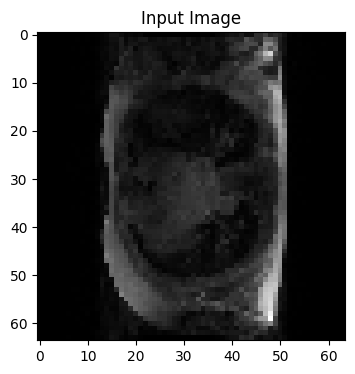

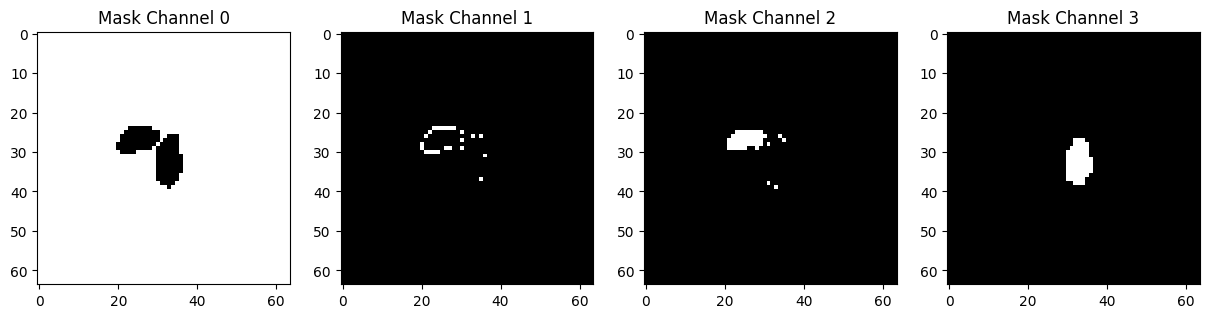

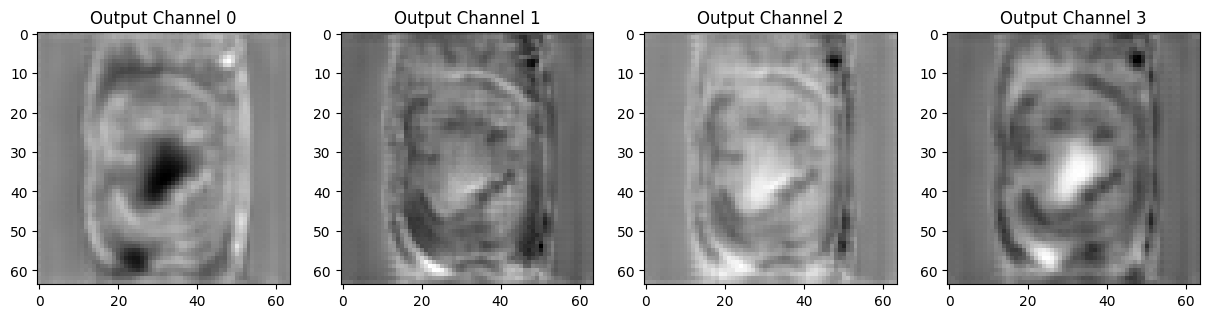

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.9921, 0.0000, 0.0448, 0.1970], device='cuda:0')
tensor([0.9915, 0.0000, 0.0352, 0.1584], device='cuda:0')
tensor([0.9921, 0.0000, 0.0130, 0.1933], device='cuda:0')


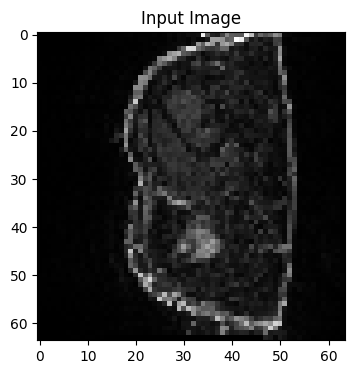

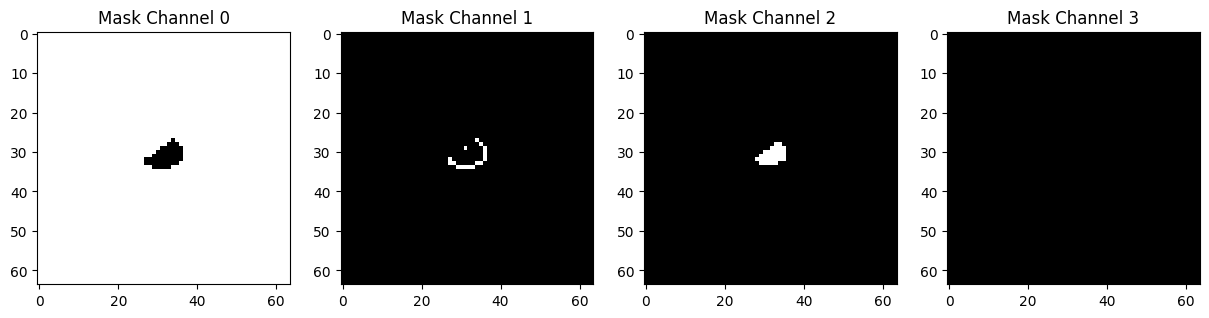

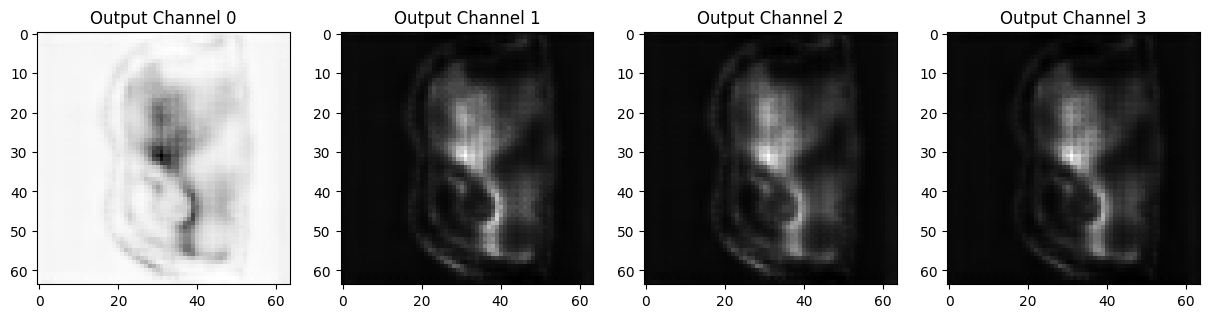

tensor([0.9921, 0.0000, 0.0000, 0.0184], device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.9920, 0.0000, 0.0000, 0.0313], device='cuda:0')
tensor([0.9905, 0.0000, 0.0000, 0.0000], device='cuda:0')
tensor([0.9918, 0.0000, 0.0000, 0.0387], device='cuda:0')
tensor([0.9922, 0.0000, 0.0000, 0.0063], device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

tensor([9.9201e-01, 0.0000e+00, 5.9067e-04, 4.6397e-02], device='cuda:0')
tensor([0.9905, 0.0000, 0.0000, 0.0000], device='cuda:0')
tensor([0.9917, 0.0000, 0.0000, 0.0122], device='cuda:0')
tensor([0.9921, 0.0000, 0.0000, 0.0000], device='cuda:0')


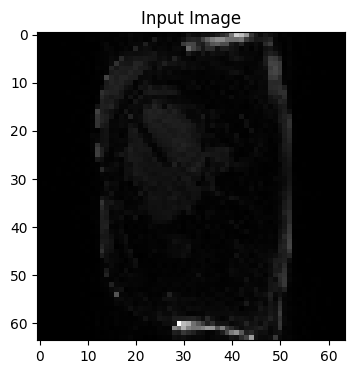

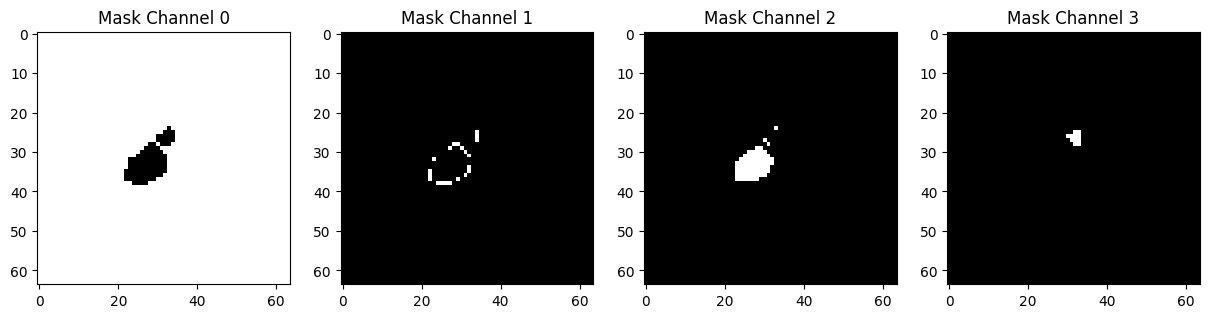

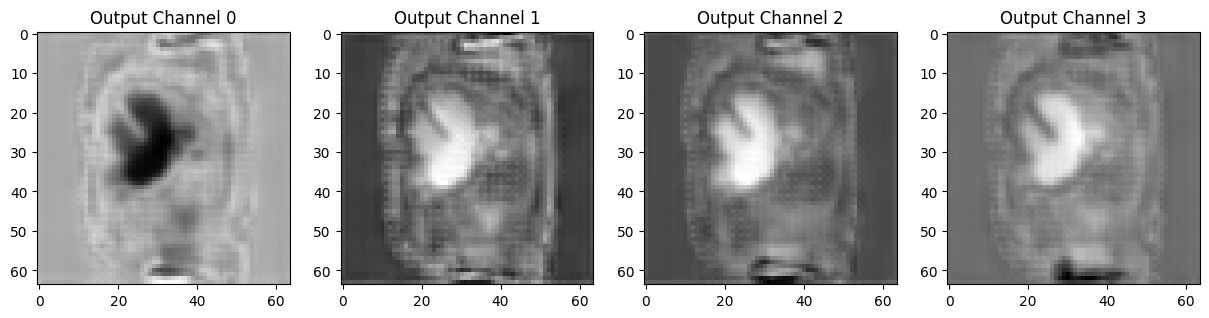

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.9927, 0.0000, 0.1536, 0.2564], device='cuda:0')
tensor([0.9912, 0.0000, 0.1724, 0.1370], device='cuda:0')
tensor([0.9923, 0.0000, 0.1277, 0.2285], device='cuda:0')


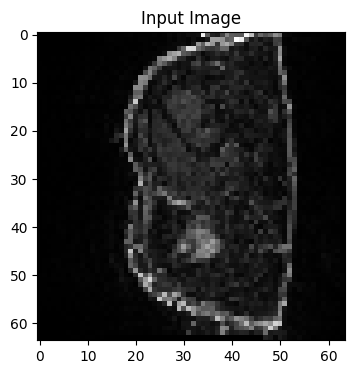

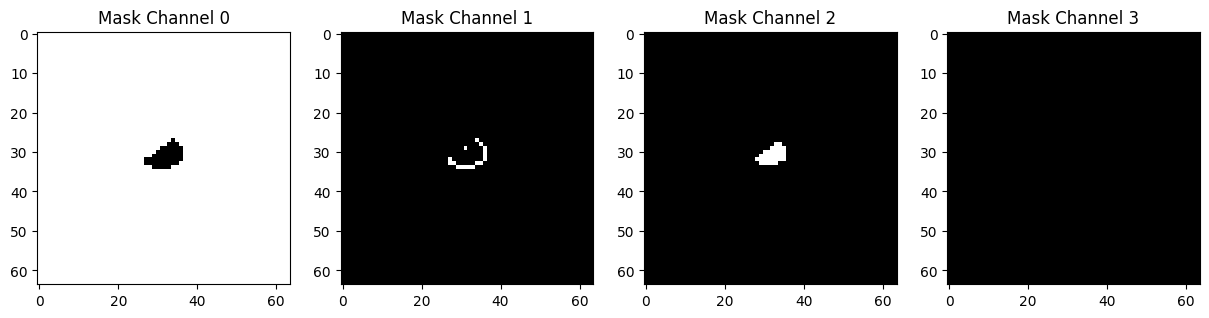

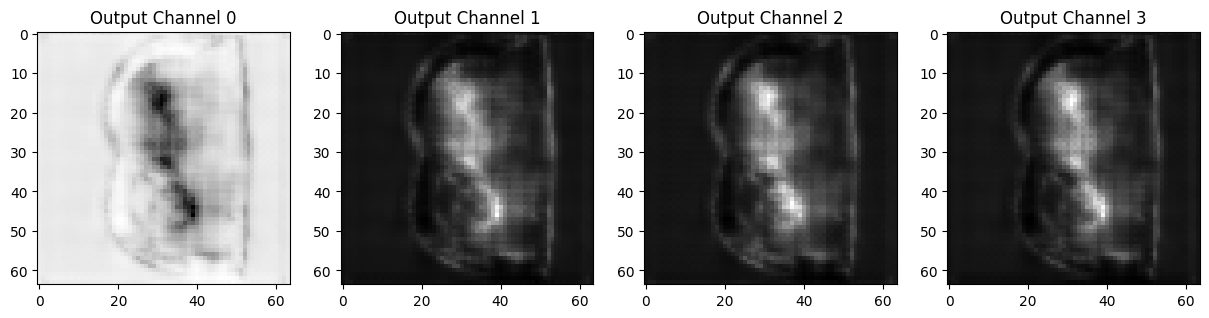

tensor([0.9921, 0.0000, 0.0000, 0.0000], device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.9932, 0.0000, 0.1863, 0.4373], device='cuda:0')
tensor([0.9911, 0.0000, 0.1515, 0.1880], device='cuda:0')
tensor([0.9922, 0.0000, 0.0602, 0.2536], device='cuda:0')
tensor([0.9923, 0.0000, 0.0000, 0.2937], device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.9918, 0.0000, 0.2073, 0.5821], device='cuda:0')
tensor([0.9931, 0.0000, 0.5125, 0.4653], device='cuda:0')
tensor([0.9885, 0.0000, 0.1582, 0.3184], device='cuda:0')
tensor([0.9917, 0.0000, 0.0173, 0.6340], device='cuda:0')


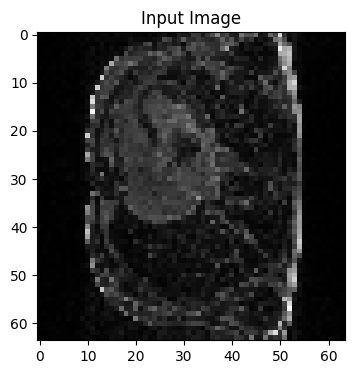

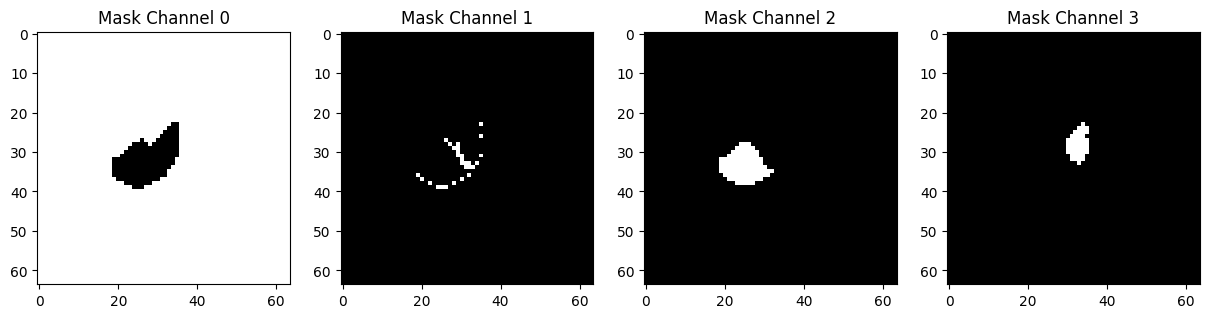

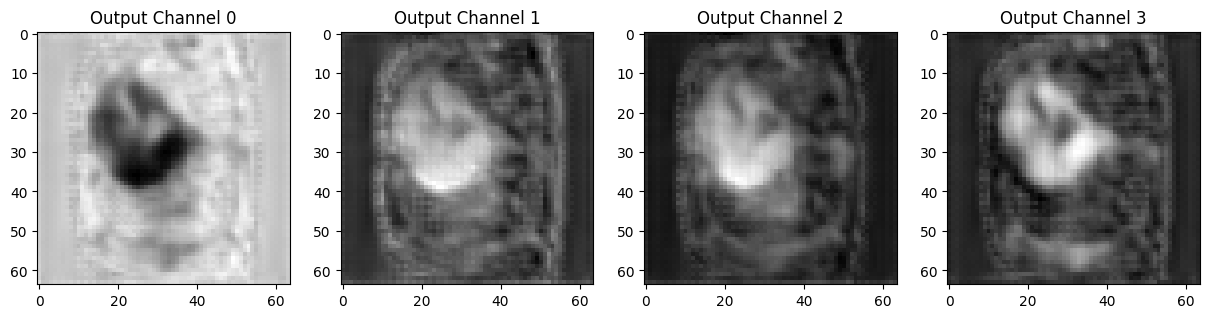

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.9928, 0.0000, 0.2647, 0.1722], device='cuda:0')
tensor([0.9908, 0.0000, 0.1479, 0.0000], device='cuda:0')
tensor([0.9925, 0.0000, 0.3059, 0.1313], device='cuda:0')


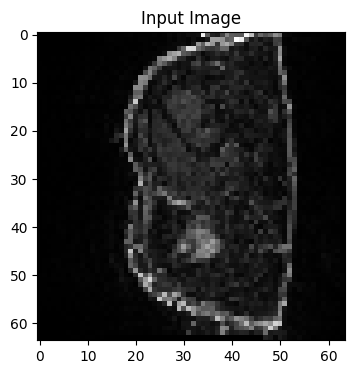

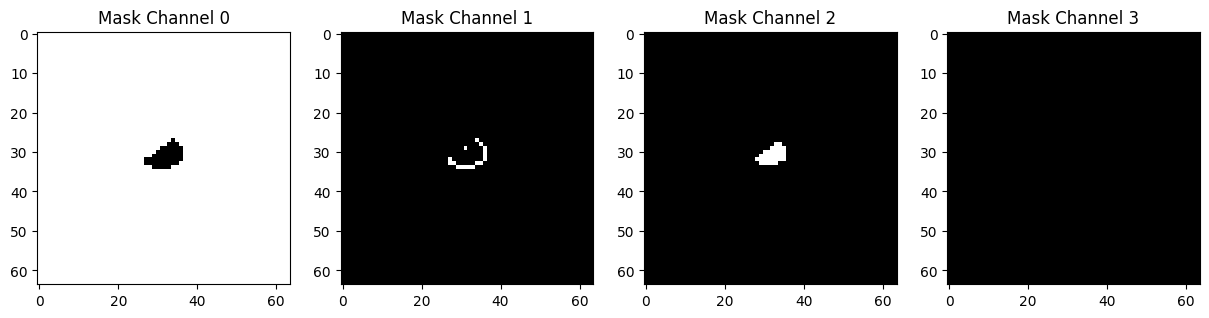

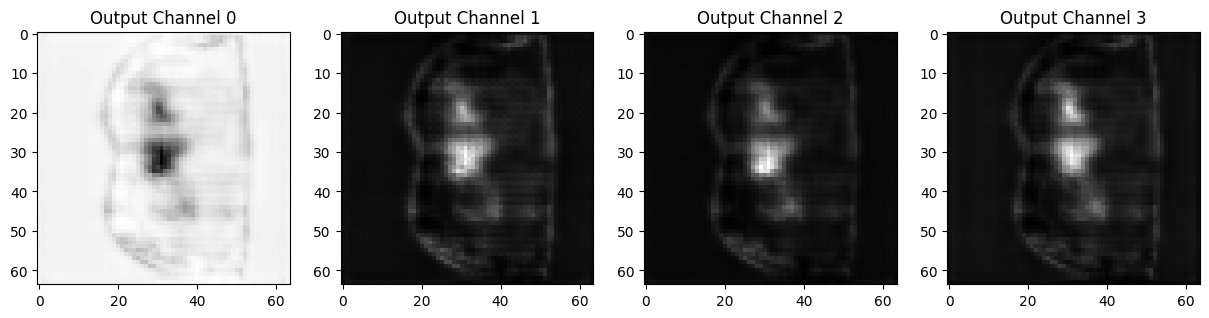

tensor([0.9928, 0.0000, 0.3243, 0.0092], device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.9933, 0.0000, 0.4555, 0.5795], device='cuda:0')
tensor([0.9900, 0.0000, 0.2622, 0.3039], device='cuda:0')
tensor([0.9894, 0.0000, 0.2345, 0.4493], device='cuda:0')
tensor([0.9918, 0.0000, 0.0303, 0.5673], device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.9921, 0.0000, 0.1198, 0.0000], device='cuda:0')
tensor([0.9905, 0.0000, 0.0000, 0.0000], device='cuda:0')
tensor([0.9917, 0.0000, 0.0000, 0.0000], device='cuda:0')
tensor([0.9922, 0.0000, 0.0475, 0.0000], device='cuda:0')


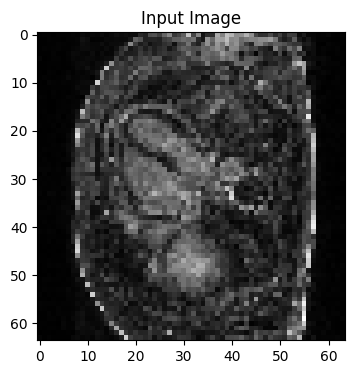

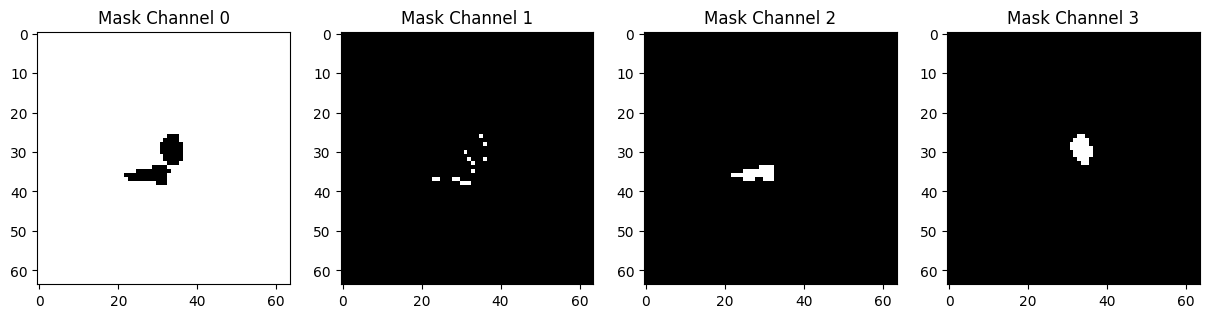

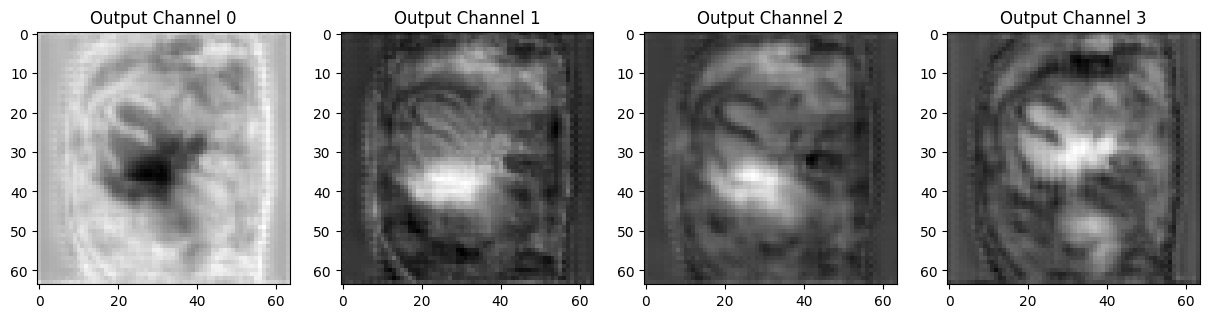

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.9926, 0.0000, 0.2739, 0.2943], device='cuda:0')
tensor([0.9920, 0.0000, 0.3930, 0.1561], device='cuda:0')
tensor([0.9930, 0.0000, 0.4143, 0.2273], device='cuda:0')


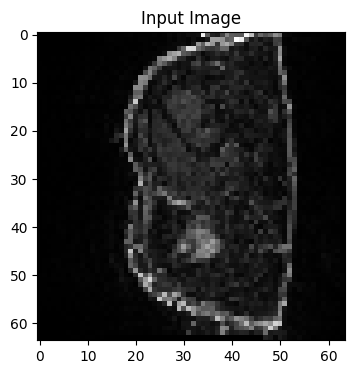

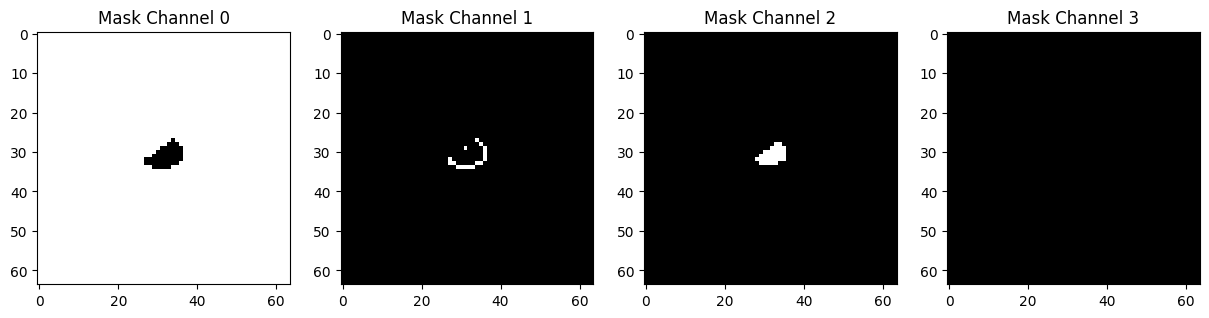

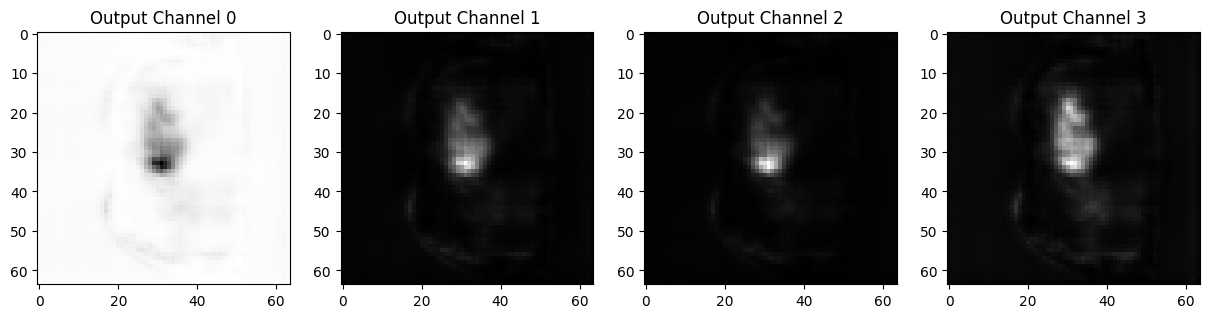

tensor([0.9937, 0.0000, 0.4722, 0.1715], device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.9927, 0.0000, 0.1104, 0.2900], device='cuda:0')
tensor([0.9912, 0.0000, 0.0824, 0.1530], device='cuda:0')
tensor([0.9925, 0.0000, 0.1668, 0.2617], device='cuda:0')
tensor([0.9931, 0.0000, 0.1794, 0.2013], device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.9934, 0.0000, 0.4462, 0.5949], device='cuda:0')
tensor([0.9931, 0.0000, 0.5647, 0.5013], device='cuda:0')
tensor([0.9907, 0.0000, 0.2869, 0.3880], device='cuda:0')
tensor([0.9946, 0.0000, 0.5244, 0.6023], device='cuda:0')


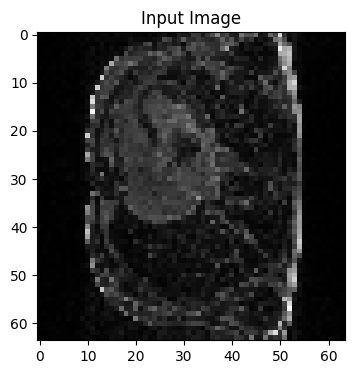

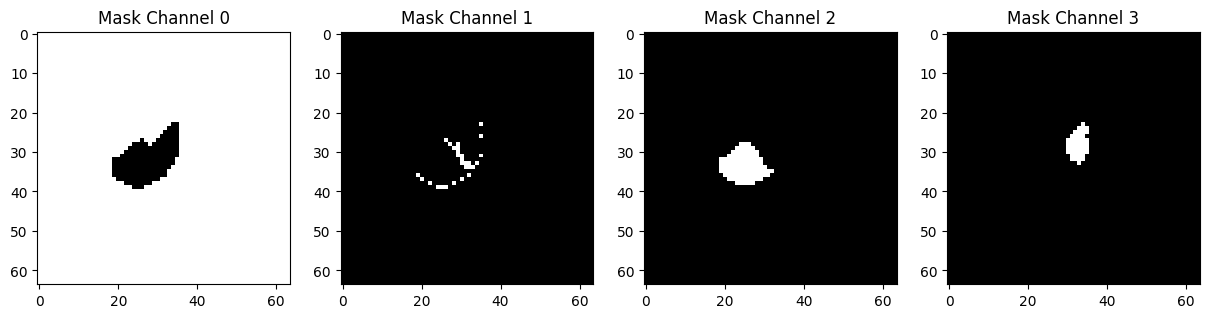

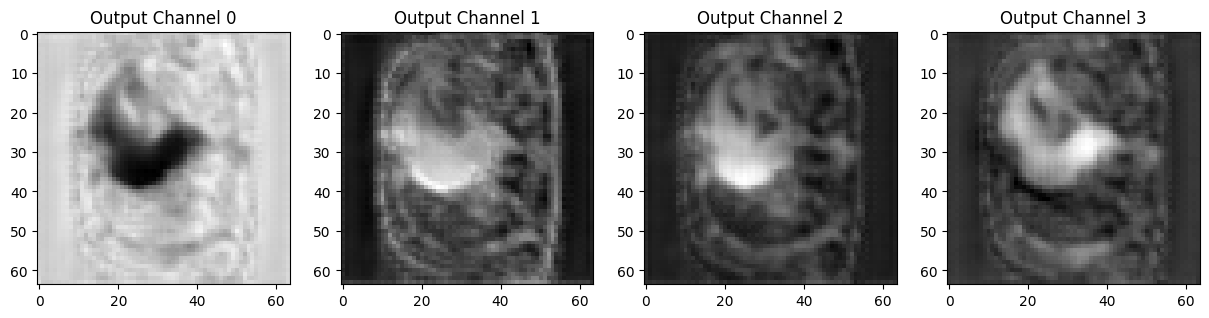

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.9944, 0.0000, 0.5550, 0.4873], device='cuda:0')
tensor([0.9927, 0.0000, 0.5051, 0.3250], device='cuda:0')
tensor([0.9933, 0.0000, 0.3841, 0.3734], device='cuda:0')


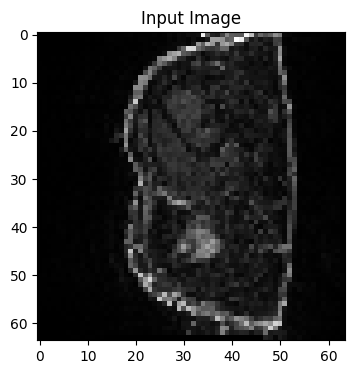

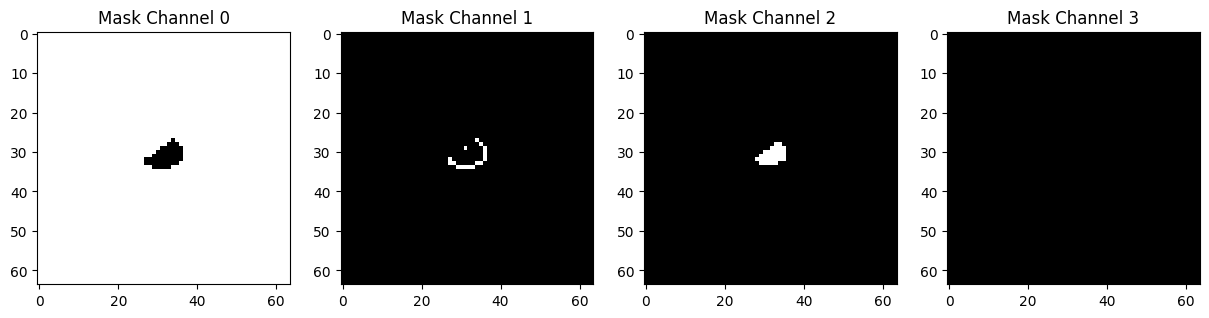

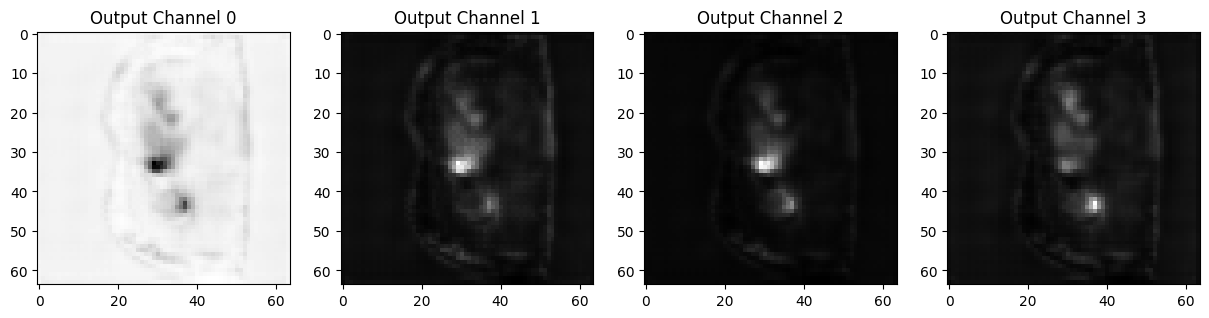

tensor([0.9940, 0.0000, 0.4712, 0.3242], device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.9936, 0.0000, 0.3804, 0.6038], device='cuda:0')
tensor([0.9933, 0.0000, 0.5208, 0.4962], device='cuda:0')
tensor([0.9935, 0.0000, 0.5063, 0.5630], device='cuda:0')
tensor([0.9922, 0.0000, 0.0526, 0.4856], device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.9922, 0.0000, 0.0641, 0.0870], device='cuda:0')
tensor([0.9910, 0.0000, 0.1442, 0.1055], device='cuda:0')
tensor([0.9923, 0.0000, 0.1756, 0.1869], device='cuda:0')
tensor([0.9927, 0.0000, 0.2307, 0.1062], device='cuda:0')


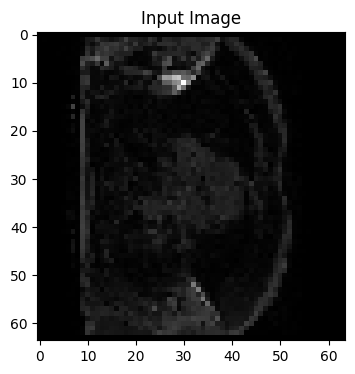

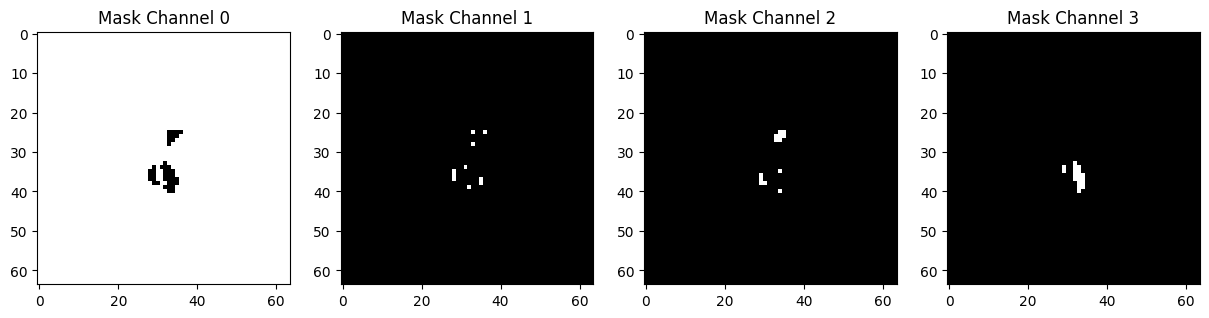

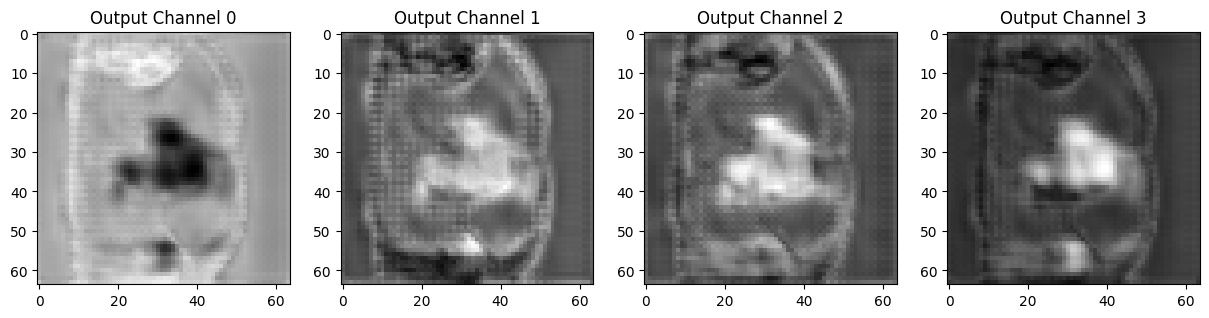

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.9943, 0.0000, 0.4043, 0.6667], device='cuda:0')
tensor([0.9925, 0.0000, 0.3592, 0.4372], device='cuda:0')
tensor([0.9937, 0.0000, 0.4905, 0.5236], device='cuda:0')


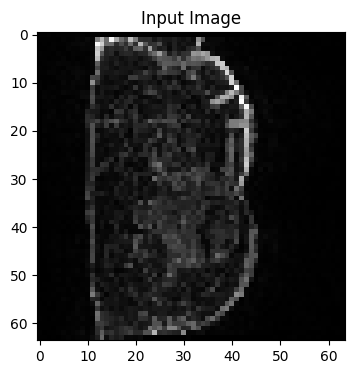

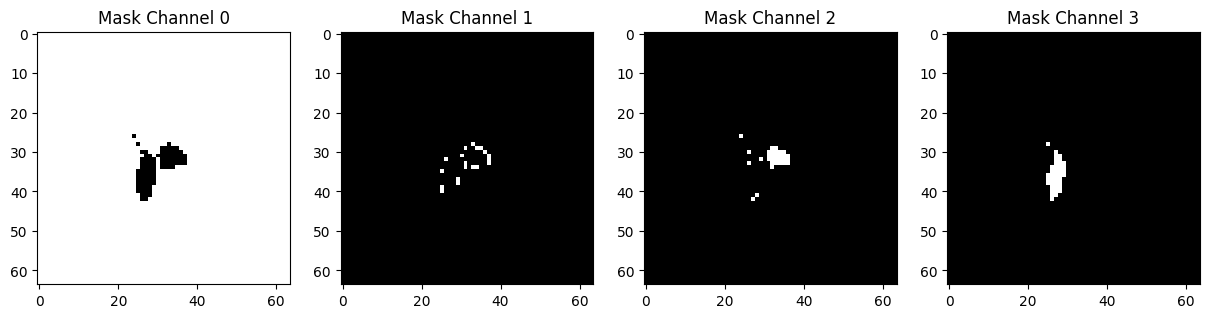

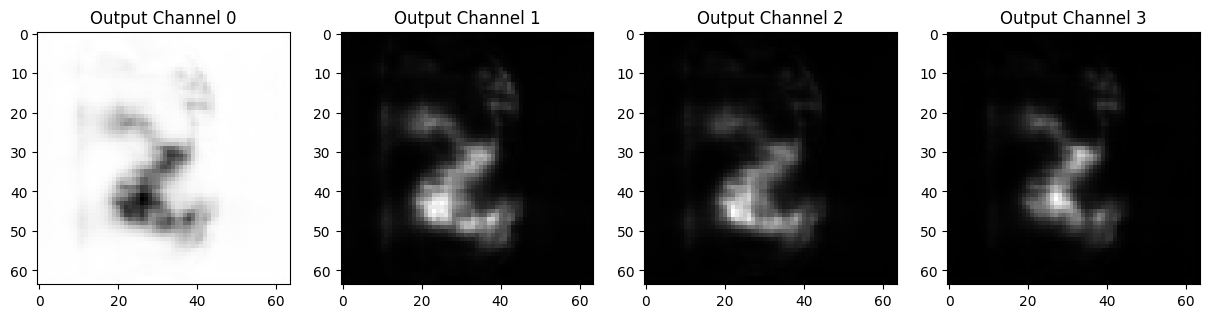

tensor([0.9931, 0.0000, 0.2535, 0.1856], device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.9948, 0.0052, 0.4782, 0.6856], device='cuda:0')
tensor([0.9919, 0.0000, 0.2418, 0.2428], device='cuda:0')
tensor([0.9925, 0.0000, 0.2541, 0.2696], device='cuda:0')
tensor([0.9949, 0.0000, 0.4396, 0.7059], device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.9947, 0.0000, 0.4823, 0.5275], device='cuda:0')
tensor([0.9920, 0.0000, 0.2245, 0.3519], device='cuda:0')
tensor([0.9937, 0.0000, 0.4130, 0.4586], device='cuda:0')
tensor([0.9950, 0.0000, 0.4978, 0.6526], device='cuda:0')


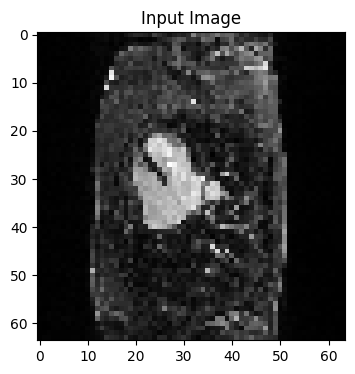

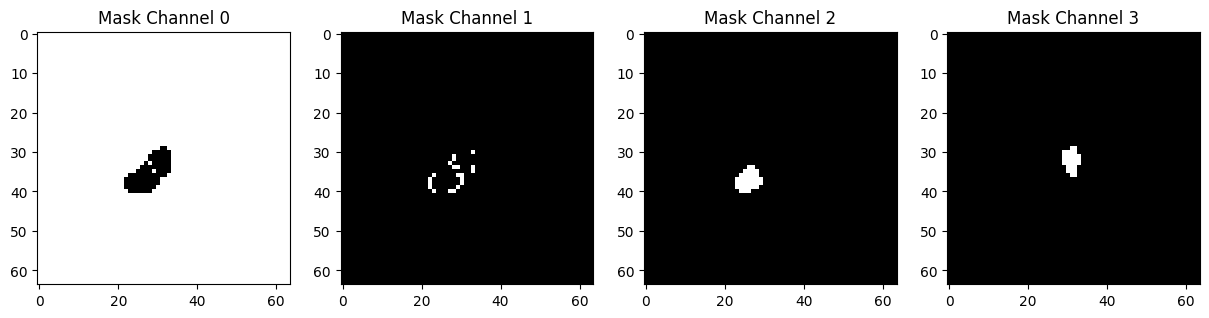

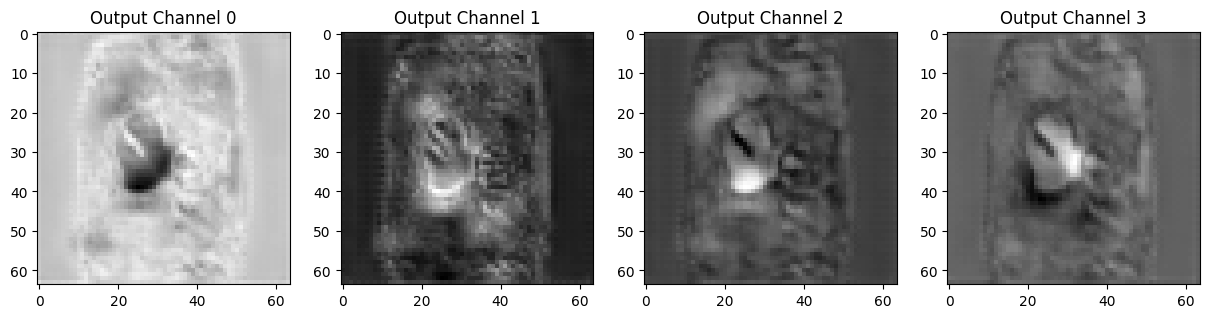

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.9952, 0.0026, 0.6101, 0.6775], device='cuda:0')
tensor([9.9287e-01, 4.4405e-04, 5.2531e-01, 5.1235e-01], device='cuda:0')
tensor([9.8997e-01, 5.0839e-04, 2.4366e-01, 2.8294e-01], device='cuda:0')


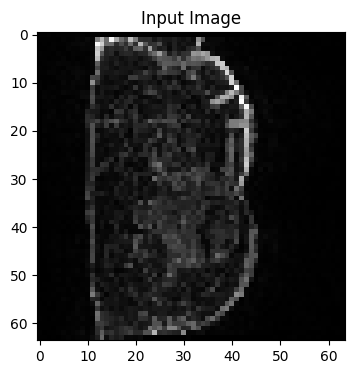

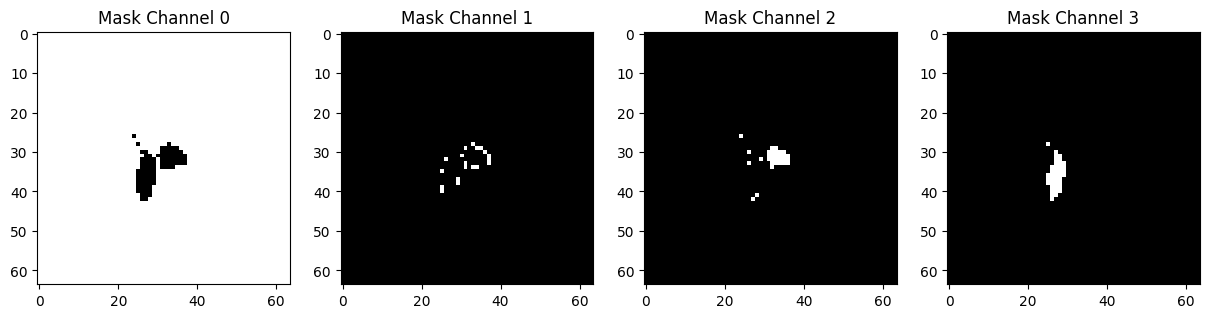

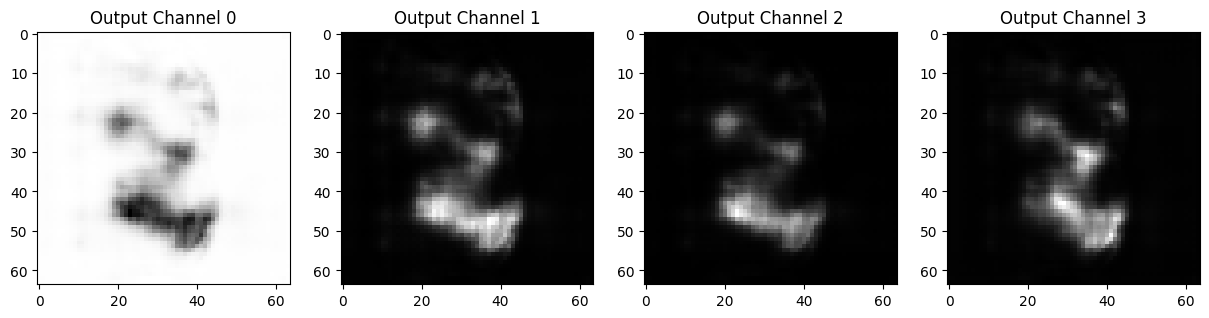

tensor([0.9936, 0.0000, 0.2862, 0.2073], device='cuda:0')


Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.9948, 0.0000, 0.5244, 0.6186], device='cuda:0')
tensor([0.9922, 0.0000, 0.1871, 0.3541], device='cuda:0')
tensor([0.9930, 0.0000, 0.3209, 0.5186], device='cuda:0')
tensor([0.9948, 0.0000, 0.4733, 0.6811], device='cuda:0')


In [ ]:
class ChooseModel:
    def __init__(self, model_name, checkpoint_path=None, **kwargs):
        self.model_name = model_name
        self.checkpoint_path = checkpoint_path
        self.kwargs = kwargs
        self.model = None
        self.loaded = False
        self.best_model_path = None

    def load_checkpoint(self):
        if self.model is not None:
            print("Model already initialized.")
            return self.model

        check = glob2.glob(self.checkpoint_path + f"/{self.model_name}*.ckpt") if self.checkpoint_path else []
        self.best_model_path = None

        if len(check) != 0:
            check.sort()
            self.best_model_path = check[-1]

            self.model = modelModule.load_from_checkpoint(model_name=self.model_name,
                                                          checkpoint_path=self.best_model_path,
                                                          **self.kwargs)
            self.loaded = True
            print("Checkpoint loaded from:", self.best_model_path)
        else:
            self.model = modelModule(self.model_name, **self.kwargs)
            print("No checkpoint found, initializing model.")

        return self.model, self.best_model_path


model_instance = ChooseModel(model_name=model_name, checkpoint_path=checkpoint_path, in_channels=IN_CHANNELS, num_classes=NUM_CLASSES, lr = lr)
model, best_model_path = model_instance.load_checkpoint()
loaded = model_instance.loaded

wandb_logger = WandbLogger(project=model_name, log_model='best')

# Define data module
train_data_module = TrainDataModule(root_dir=rootDir, transform_array=transform_array, train_split=train_split, batch_size=batch_size,shuffle=True)
test_data_module = TestDataModule(root_dir=rootDir, transform_array=transform_array, batch_size=batch_size)

trainer_params = {
    'max_epochs': 1000,
    'callbacks': [checkpoint_callback, early_stopping],
    'accelerator': 'gpu',
    'logger': wandb_logger
}

if model_name == "UNETR" or model_name=="UNETRSOFTMAX": # or model_name == "SmallUNETR" or model_name == "TinyUNETR":
    print("MIXED PRECISION")
    trainer_params['precision'] = "16-mixed"

# Pass the trainer_params dictionary as keyword arguments (**kwargs)
trainer = Trainer(**trainer_params)

if to_train_and_test == True:
    if loaded:
        trainer.fit(model, datamodule=train_data_module,ckpt_path=best_model_path)

        trainer.test(model, dataloaders=test_data_module,ckpt_path=best_model_path)
    else:
        trainer.fit(model, datamodule=train_data_module)

        trainer.test(model, dataloaders=test_data_module)


# SAVE PREDICTED OUTPUTS BY TRAINED MODELS

In [ ]:
#for_training = True

save_for_training = True
save_for_validation = True

batch_size_to_save = 1

In [ ]:
'''
# Initialize your data module with appropriate arguments
prediction_data_module = TrainDataModule(root_dir=rootDir, transform_array=transform_array, train_split=train_split, batch_size=1, shuffle=False, random_opening=False)
prediction_data_module.setup()  # Set up the data

# Get the training dataloader
prediction_loader = prediction_data_module.train_dataloader() if for_training==True else prediction_data_module.val_dataloader()
label_saved = False

# Function to plot a specific slice from the masks (labels) tensor
def plot_label_slice_from_tensor(masks, batch_index=0, slice_index=32):
    # Ensure the tensor has the expected shape (batch_dim, channels, w, h, d)
    print(f"Masks shape: {masks.shape}")
    for channel in range(masks.shape[1]):
        # Extract the desired batch, channel, and slice
        label_slice = masks[batch_index, channel, :, :, slice_index].cpu().numpy()  # Convert to numpy for plotting

        # Plot the selected slice
        plt.figure(figsize=(6, 6))
        plt.imshow(label_slice, cmap='gray')
        plt.title(f"LABEL: Batch {batch_index}, Slice {slice_index}, channel {channel}")
        plt.axis('off')
        plt.show()


# Function to perform inference and save outputs
def predict_and_save(model, model_name, dataloader, output_path_prefix):
    model.eval()
    with torch.no_grad():  # No gradient calculation required during inference
        for batch_idx, (images, masks) in enumerate(dataloader):
            #num_pairs_in_batch = len(images)  # Since image and mask are paired
            #print(f"Batch {batch_idx} contains {num_pairs_in_batch} image-mask pairs.")
            #print(images.shape)

            current_batch_size = images.size(0)

            # Check if the batch size is less than the expected size
            if current_batch_size < batch_size_to_save:
                print(f"Batch {batch_idx} has {current_batch_size} samples. Padding to batch size {batch_size_to_save}.")

                # Repeat samples from the last batch to match the desired batch size
                repeat_count = batch_size_to_save - current_batch_size
                images = torch.cat([images] + [images[:repeat_count]], dim=0)
                masks = torch.cat([masks] + [masks[:repeat_count]], dim=0)

                print(f"Padded batch {batch_idx} to {images.size(0)} samples.")

            images = images.to(device)  # Move images to the same device as the model
            output = model(images)  # Predict the output for the entire batch
            torch.save(output.cpu(), f"{output_path_prefix}/{'' if for_training==True else 'val_'}{model_name}_output_{batch_idx}.pth")
            print(f"Saved output for batch {batch_idx} into {output_path_prefix}/{model_name}_output_{batch_idx}.pth")
            print(f"SHAPE: {output.cpu().shape}")
            if label_saved == False:
              torch.save(masks.cpu(), f"{output_path_prefix}/{'' if for_training==True else 'val_'}label_{batch_idx}.pth")
              print(f"Saved label for batch {batch_idx} into {output_path_prefix}/label_{batch_idx}.pth")

             # Plot specific batches and slices (e.g., batch 1 and 7, slice index 32)
            if batch_idx in [1, 7]:
                # Directly plot from the masks (labels) tensor
                plot_label_slice_from_tensor(masks, batch_index=0, slice_index=0)
                plot_label_slice_from_tensor(masks, batch_index=0, slice_index=32)
                plot_label_slice_from_tensor(masks, batch_index=0, slice_index=63)


#base_models = ["UNET3D", "SmallUNET3D", "TinyUNET3D", "AUNET3D", "SmallAUNET3D", "TinyAUNET3D", "UNETR", "SmallUNETR", "TinyUNETR"]
base_models = ["UNETRSOFTMAX", "SmallUNETRSOFTMAX"]
if for_training != None:
    for model_name in base_models:
        model_instance = ChooseModel(model_name=model_name, checkpoint_path=checkpoint_path, in_channels=IN_CHANNELS, num_classes=NUM_CLASSES, lr=lr)
        model, best_model_path = model_instance.load_checkpoint()
        loaded = model_instance.loaded
        if loaded != True:
          print(f"PROBLEM WITH {model_name}, SKIPPED")
        else:
          predict_and_save(model, model_name, prediction_loader, save_dir_predictions)
          label_saved = True
'''
# Example flags to control which stages to save predictions
save_for_training = True
save_for_validation = True

# Initialize your data module with appropriate arguments
prediction_data_module = TrainDataModule(root_dir=rootDir, transform_array=transform_array, train_split=train_split, batch_size=1, shuffle=False, random_opening=False)
prediction_data_module.setup()  # Set up the data

# Function to plot a specific slice from the masks (labels) tensor
def plot_label_slice_from_tensor(masks, batch_index=0, slice_index=32):
    # Ensure the tensor has the expected shape (batch_dim, channels, w, h, d)
    print(f"Masks shape: {masks.shape}")
    for channel in range(masks.shape[1]):
        # Extract the desired batch, channel, and slice
        label_slice = masks[batch_index, channel, :, :, slice_index].cpu().numpy()  # Convert to numpy for plotting

        # Plot the selected slice
        plt.figure(figsize=(6, 6))
        plt.imshow(label_slice, cmap='gray')
        plt.title(f"LABEL: Batch {batch_index}, Slice {slice_index}, channel {channel}")
        plt.axis('off')
        plt.show()

# Function to perform inference and save outputs for training/validation
def predict_and_save(model, model_name, dataloader, output_path_prefix, save_predictions, label_saved):
    model.eval()
    with torch.no_grad():  # No gradient calculation required during inference
        for batch_idx, (images, masks) in enumerate(dataloader):
            current_batch_size = images.size(0)

            # Check if the batch size is less than the expected size
            if current_batch_size < batch_size_to_save:
                print(f"Batch {batch_idx} has {current_batch_size} samples. Padding to batch size {batch_size_to_save}.")
                repeat_count = batch_size_to_save - current_batch_size
                images = torch.cat([images] + [images[:repeat_count]], dim=0)
                masks = torch.cat([masks] + [masks[:repeat_count]], dim=0)
                print(f"Padded batch {batch_idx} to {images.size(0)} samples.")

            images = images.to(device)  # Move images to the same device as the model
            output = model(images)  # Predict the output for the entire batch

            if save_predictions:
                # Save predictions for the current stage (training/validation)
                torch.save(output.cpu(), f"{output_path_prefix}/{model_name}_output_{batch_idx}.pth")
                print(f"Saved output for batch {batch_idx} into {output_path_prefix}/{model_name}_output_{batch_idx}.pth")
                print(f"SHAPE: {output.cpu().shape}")

                # Save labels once per run (only for the first batch)
                if not label_saved:
                    torch.save(masks.cpu(), f"{output_path_prefix}/label_{batch_idx}.pth")
                    print(f"Saved label for batch {batch_idx} into {output_path_prefix}/label_{batch_idx}.pth")
                    label_saved = True

            # Plot specific batches and slices (e.g., batch 1 and 7, slice index 32)
            if batch_idx in [1, 7]:
                plot_label_slice_from_tensor(masks, batch_index=0, slice_index=0)
                plot_label_slice_from_tensor(masks, batch_index=0, slice_index=32)
                plot_label_slice_from_tensor(masks, batch_index=0, slice_index=63)

    return label_saved  # Return the updated label_saved flag


# Main loop to process models
base_models = ["TinyUNETRSOFTMAX"]
for model_name in base_models:
    model_instance = ChooseModel(model_name=model_name, checkpoint_path=checkpoint_path, in_channels=IN_CHANNELS, num_classes=NUM_CLASSES, lr=lr)
    model, best_model_path = model_instance.load_checkpoint()
    loaded = model_instance.loaded

    if not loaded:
        print(f"PROBLEM WITH {model_name}, SKIPPED")
        continue

    label_saved = False  # Track label saving across training and validation stages

    # Saving for training
    if save_for_training:
        prediction_loader = prediction_data_module.train_dataloader()
        label_saved = predict_and_save(model, model_name, prediction_loader, save_dir_predictions, save_for_training, label_saved)

    # Saving for validation
    if save_for_validation:
        prediction_loader = prediction_data_module.val_dataloader()
        predict_and_save(model, f"val_{model_name}", prediction_loader, save_dir_predictions, save_for_validation, label_saved)



# MODEL ENSAMBLING

https://arxiv.org/abs/2104.02395

https://www.sciencedirect.com/science/article/pii/S1319157823000228?ref=pdf_download&fr=RR-2&rr=8c8bb755ed114bf3


the idea is to make inference on training data, and evaluate different approaches for ensambling using validation data

## STACKING APPROACH WITH META-LEARNER

Since the base models will output logits for 4 classes, the meta-model will combine the predictions from all base models and produce a final prediction.

### META-LEARNER AND DATA LOADING

In [ ]:
meta_learner_to_train = False #bool to decide if starting the training or not

In [ ]:
''' ENSAMBLIN OVER THE CHANNEL DIMENSIONS
class MetaModelDataset(Dataset):
    def __init__(self, predictions_paths, label_paths, num_models=9, batch_size=4):
        """
        predictions_paths: List of paths to the saved batch predictions from base models.
        label_paths: List of paths to the saved individual labels.
        batch_size: Number of images in each batch.
        num_models: Number of base models (default=9).
        """
        self.predictions_paths = predictions_paths
        self.label_paths = label_paths
        self.batch_size = batch_size
        self.num_models = num_models
        self.num_batches = len(predictions_paths) // num_models  # Assumes each batch is split across models

    def load_and_concatenate_outputs(self, prediction_paths):
        """
        Load and concatenate predictions from the base models for a given batch.
        Each prediction is assumed to have 4 channels (for 4 classes).
        """
        predictions = [torch.load(path).float() for path in prediction_paths]  # Load predictions as float
        # Concatenate predictions along the channel axis (dim=1)
        concatenated_outputs = torch.cat(predictions, dim=1)  # Shape: [batch_size, num_models * num_classes, D, H, W]
        concatenated_outputs = concatenated_outputs.squeeze(0)
        return concatenated_outputs

    def __getitem__(self, idx):
        """
        Get the aggregated predictions from the base models for batch `idx` and the corresponding label.
        """
        # Find the prediction paths corresponding to this batch
        batch_prediction_paths = [path for path in self.predictions_paths if path.split('_')[-1].split('.')[0] == str(idx)]
        # Load and concatenate the predictions
        concatenated_predictions = self.load_and_concatenate_outputs(batch_prediction_paths)

        # Load the corresponding label
        label = torch.load(self.label_paths[idx]).squeeze(0)#.float()  # Load label and convert to long (class labels)
        return concatenated_predictions, label

    def __len__(self):
        # Length is based on the number of batches of labels
        return self.num_batches
'''
class MetaModelDataset(Dataset):
    def __init__(self, predictions_paths, label_paths, num_models=9, batch_size=4):
        """
        predictions_paths: List of paths to the saved batch predictions from base models.
        label_paths: List of paths to the saved individual labels.
        batch_size: Number of images in each batch.
        num_models: Number of base models (default=9).
        """
        self.predictions_paths = predictions_paths
        self.label_paths = label_paths
        self.batch_size = batch_size
        self.num_models = num_models
        self.num_batches = len(predictions_paths) // num_models  # Assumes each batch is split across models

    def load_and_stack_outputs(self, prediction_paths):
        """
        Load and stack predictions from the base models for a given batch.
        Each prediction is assumed to have 4 channels (for 4 classes).
        """
        predictions = [torch.load(path).float() for path in prediction_paths]  # Load predictions as float
        # Stack predictions along a new dimension (for models), resulting shape: [batch_size, num_models, num_classes, D, H, W]
        stacked_outputs = torch.stack(predictions, dim=1)  # Stack along the new "model" dimension
        return stacked_outputs

    def __getitem__(self, idx):
        """
        Get the stacked predictions from the base models for batch `idx` and the corresponding label.
        """
        # Find the prediction paths corresponding to this batch
        batch_prediction_paths = [path for path in self.predictions_paths if path.split('_')[-1].split('.')[0] == str(idx)]
        # Load and stack the predictions
        stacked_predictions = self.load_and_stack_outputs(batch_prediction_paths)

        # Load the corresponding label
        label = torch.load(self.label_paths[idx]).squeeze(0)
        return stacked_predictions, label

    def __len__(self):
        # Length is based on the number of batches of labels
        return self.num_batches

In [ ]:
class MetaModelDataModule(LightningDataModule):
    def __init__(self, save_dir_predictions, num_models=9, batch_size=4, shuffle=True):
        """
        save_dir_predictions: Directory where the predictions and labels are saved.
        num_models: Number of base models.
        batch_size: Number of images in each batch.
        shuffle: Whether to shuffle the training data.
        """
        super().__init__()
        self.save_dir_predictions = save_dir_predictions
        self.num_models = num_models
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.train_predictions_paths = []
        self.val_predictions_paths = []
        self.train_label_paths = []
        self.val_label_paths = []

    def setup(self, stage=None):
        """
        Set up the training and validation datasets.
        """
        # Get all predictions and label paths
        all_predictions_paths = glob2.glob(f'{self.save_dir_predictions}/*.pth')
        all_predictions_paths.sort()

        # Split into training and validation based on the "val" string in file names
        self.train_predictions_paths = [path for path in all_predictions_paths if 'val' not in path]
        self.val_predictions_paths = [path for path in all_predictions_paths if 'val' in path]
        # Collect the label paths (without 'val' for training and with 'val' for validation)
        self.train_label_paths = [path for path in self.train_predictions_paths if 'label' in path]
        self.val_label_paths = [path for path in self.val_predictions_paths if 'label' in path]
        # Remove label paths from the predictions lists
        self.train_predictions_paths = [path for path in self.train_predictions_paths if 'label' not in path]
        self.val_predictions_paths = [path for path in self.val_predictions_paths if 'label' not in path]

    def train_dataloader(self):
        """
        Return DataLoader for training set.
        """
        train_dataset = MetaModelDataset(predictions_paths=self.train_predictions_paths, label_paths=self.train_label_paths, num_models=self.num_models)
        return DataLoader(train_dataset, batch_size=self.batch_size, shuffle=self.shuffle)

    def val_dataloader(self):
        """
        Return DataLoader for validation set.
        """
        val_dataset = MetaModelDataset(predictions_paths=self.val_predictions_paths, label_paths=self.val_label_paths, num_models=self.num_models)
        return DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)


In [ ]:
''' ENSAMBLIN OVER THE CHANNEL DIMENSIONS

class MetaModelLightning(pl.LightningModule):
    def __init__(self, num_base_models=9, lr=0.0005, class_weights=None):
        super(MetaModelLightning, self).__init__()
        self.save_hyperparameters()

        self.num_base_models = num_base_models
        self.lr = lr
        self.class_weights = class_weights

        # Input channels: num_base_models * 4 because each base model outputs 4 channels
        self.conv1 = nn.Conv3d(in_channels=num_base_models * 4, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(128, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(256, 128, kernel_size=3, padding=1)
        self.final_conv = nn.Conv3d(128, 4, kernel_size=1)  # 4 output classes (channels)

        self.relu = nn.ReLU()
        #self.bn1 = nn.BatchNorm3d(128)
        #self.bn2 = nn.BatchNorm3d(256)
        self.dropout = nn.Dropout3d(p=0.2)
        self.init_dropout = nn.Dropout3d(p=0.1)

    def forward(self, x):
        #x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.conv1(x))
        x = self.init_dropout(x)
        #x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.relu((self.conv3(x)))
        x = self.dropout(x)
        x = self.final_conv(x)
        return x

    def training_step(self, batch, batch_idx):
        base_preds, labels = batch
        outputs = self(base_preds)

        outputs = outputs.float()
        labels = labels.float()

        # Loss: CrossEntropyLoss for multi-class segmentation
        loss = nn.CrossEntropyLoss()(outputs, labels)

        # Optionally plot a slice for visualization
        if batch_idx == 0:
            print( f"BEFORE PLOTTING {base_preds.shape}, {labels.shape}, {outputs.shape}")
            last_image = base_preds[-1, :, :, :, :]
            last_mask = labels[-1, :, :, :, :]
            last_output = outputs[-1, :, :, :, :]
            self.plot_slice(last_image, last_mask, last_output, self.current_epoch)

        # Calculate Dice score
        preds = outputs.argmax(dim=1)
        labels = labels.argmax(dim=1)

        dice_score = dice(preds, labels).detach()

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_dice', dice_score, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        base_preds, labels = batch
        outputs = self(base_preds)

        outputs = outputs.float()
        labels = labels.float()

        # Loss: CrossEntropyLoss for multi-class segmentation
        loss = nn.CrossEntropyLoss()(outputs, labels)

        # Optionally plot a slice for visualization
        if batch_idx == 0:  # Just plotting the first batch for example
            print( f"BEFORE PLOTTING {base_preds.shape}, {labels.shape}, {outputs.shape}")
            last_image = base_preds[-1, :, :, :, :]
            last_mask = labels[-1, :, :, :, :]
            last_output = outputs[-1, :, :, :, :]
            self.plot_slice(last_image, last_mask, last_output, self.current_epoch)

        # Calculate Dice score
        preds = outputs.argmax(dim=1)  # Get predicted class indices directly from logits
        labels = labels.argmax(dim=1)

        dice_score = dice(preds, labels).detach()
        score_none = dice(preds, labels, average=None, num_classes=4).detach()

        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_dice', dice_score, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        print(score_none)

        return loss

    def plot_slice(self, last_image, last_mask, last_output, epoch , NUM_CLASSES=4):
      plt.figure(figsize=(4,4))
      plt.imshow(last_image[0, :, :, 21].cpu().numpy(), cmap='gray')
      plt.title('Input Image')
      plt.show()

      if last_mask != None:
          fig, axs = plt.subplots(nrows=1, ncols=NUM_CLASSES, figsize=(15, 15))
          for i in range(NUM_CLASSES):
              axs[i].imshow(last_mask[i, :, :, 21].cpu().numpy(), cmap='gray')
              axs[i].set_title(f'Mask Channel {i}')
          plt.show()

      fig, axs = plt.subplots(nrows=1, ncols=NUM_CLASSES, figsize=(15, 15))
      for i in range(NUM_CLASSES):
          axs[i].imshow(last_output[i, :, :, 21].detach().cpu().numpy(), cmap='gray')
          axs[i].set_title(f'Output Channel {i}')
      plt.show()

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.lr)
        #scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.5, patience=5)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0, patience=5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

'''

class MetaModelLightning(pl.LightningModule):
    def __init__(self, num_base_models=9, lr=0.0005, class_weights=None):
        super(MetaModelLightning, self).__init__()
        self.save_hyperparameters()

        self.num_base_models = num_base_models
        self.lr = lr
        self.class_weights = class_weights

        # Modify the input channels to handle the new "model" dimension.
        self.conv1 = nn.Conv3d(in_channels=4, out_channels=128, kernel_size=3, padding=1)  # Only 4 channels (one model's channels)
        self.conv2 = nn.Conv3d(128, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(256, 128, kernel_size=3, padding=1)
        self.final_conv = nn.Conv3d(128, 4, kernel_size=1)  # 4 output classes (channels)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout3d(p=0.2)
        self.init_dropout = nn.Dropout3d(p=0.1)

        # Aggregation layer for models
        self.aggregation = nn.Conv3d(in_channels=num_base_models, out_channels=1, kernel_size=1)

    def forward(self, x):
        """
        The input now has an additional dimension for models: [batch_size, num_models, channels, D, H, W]
        We first aggregate over the model dimension.
        """
        # Aggregate over the model dimension using a 1x1x1 convolution
        x = self.aggregation(x)  # Shape after aggregation: [batch_size, 1, channels, D, H, W]
        x = torch.squeeze(x, dim=1)  # Remove the model dimension: [batch_size, channels, D, H, W]

        x = self.relu(self.conv1(x))
        x = self.init_dropout(x)
        x = self.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.final_conv(x)
        return x

    def training_step(self, batch, batch_idx):
        base_preds, labels = batch
        outputs = self(base_preds)

        outputs = outputs.float()
        labels = labels.float()

        # Loss: CrossEntropyLoss for multi-class segmentation
        loss = nn.CrossEntropyLoss()(outputs, labels)

        if batch_idx == 0:
            print(f"BEFORE PLOTTING {base_preds.shape}, {labels.shape}, {outputs.shape}")
            last_image = base_preds[-1, :, :, :, :]  # Last image of batch
            last_mask = labels[-1, :, :, :, :]  # Last label mask
            last_output = outputs[-1, :, :, :, :]  # Last output

            self.plot_slice(last_image, last_mask, last_output, self.current_epoch)

        preds = outputs.argmax(dim=1)
        labels = labels.argmax(dim=1)

        dice_score = dice(preds, labels).detach()

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_dice', dice_score, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

In [ ]:
''' To Test
def training_step(self, batch, batch_idx):
    base_preds, labels = batch
    outputs = self(base_preds)

    # outputs is [batch_size, num_classes, D, H, W]
    outputs = outputs.float()

    # Ensure labels are class indices for CrossEntropyLoss
    labels = labels.long()

    # Loss: CrossEntropyLoss for multi-class segmentation
    loss = nn.CrossEntropyLoss()(outputs, labels)

    if batch_idx == 0:
        print(f"BEFORE PLOTTING {base_preds.shape}, {labels.shape}, {outputs.shape}")
        last_image = base_preds[-1, :, :, :, :]  # Last image of batch
        last_mask = labels[-1, :, :, :]  # Last label mask (class indices, not one-hot)
        last_output = outputs[-1, :, :, :, :]  # Last output

        self.plot_slice(last_image, last_mask, last_output, self.current_epoch)

    preds = outputs.argmax(dim=1)  # Predicted class indices
    dice_score = dice(preds, labels).detach()

    self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    self.log('train_dice', dice_score, on_step=True, on_epoch=True, prog_bar=True, logger=True)

    return loss

'''


In [ ]:
if meta_learner_to_train == True:
    # Initialize the MetaModelDataModule with appropriate paths and settings
    meta_data_module = MetaModelDataModule(save_dir_predictions=save_dir_predictions, num_models=9, batch_size=4, shuffle=True)
    # Initialize the meta-model
    meta_model = MetaModelLightning(num_base_models=9, lr=0.0005)

    # Define ModelCheckpoint callback
    checkpoint_callback_ML = ModelCheckpoint(
        dirpath=save_dir,  # Specify checkpoint directory
        filename="metaLearner",  # Filename format with epoch number
        monitor="val_loss",  # Metric to monitor for saving best models
        mode="min",  # Save the model with the lowest monitored metric
        save_top_k=2  # Keep the top 2 best models based on the monitored metric
    )
    early_call = pl.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")
    # Trainer
    trainer_params = {
        'max_epochs': 150,
        'callbacks': [checkpoint_callback_ML, early_call],
        'accelerator': 'gpu',
        'logger': wandb_logger
    }

    # Pass the trainer_params dictionary as keyword arguments (**kwargs)
    trainer = Trainer(**trainer_params)

    # Train the meta-model using the data module
    trainer.fit(meta_model, meta_data_module)


## ENSAMBLING USING STANDARD OPERATORS

In [ ]:
''' AGGREGATION ON CHANNELS
def plot_prediction_slice(ensembled_preds, predictions_list, label, model_names, channel=None, slice_idx=32):
    """
    Plot slices of the ensembled predictions, individual model predictions, and the ground truth label.

    Args:
    - ensembled_preds: Tensor of ensembled predictions (shape: [1, 4, 64, 64, 64]).
    - predictions_list: List of individual model predictions.
    - label: Ground truth label tensor (shape: [1, 4, 64, 64, 64]).
    - model_names: List of model names to display in the plots.
    - channel: The channel (class) to visualize. If None, plot all channels.
    - slice_idx: The index of the slice to visualize (default: 32).
    """

    # Determine the number of channels (assuming the shape is [batch, num_classes, H, W, D])
    num_channels = ensembled_preds.shape[1]

    # If channel is None, plot all channels; otherwise, plot the specified one
    channels_to_plot = list(range(num_channels)) if channel is None else [channel]

    # Number of rows needed for the plot
    num_rows = len(channels_to_plot)

    for ch in channels_to_plot:
        num_models = len(predictions_list)

        plt.figure(figsize=(20, 5 * num_rows))  # Adjust height according to the number of rows

        # Plot individual model predictions for this channel
        for i, model_pred in enumerate(predictions_list):
            model_prediction = model_pred[0]  # Remove batch dimension (shape: [4, 64, 64, 64])
            channel_prediction = model_prediction[ch]  # Get the specific channel (shape: [64, 64, 64])
            slice_prediction = channel_prediction[slice_idx, :, :]  # Extract the slice (shape: [64, 64])

            # Create subplot for each model's prediction for this channel
            plt.subplot(num_rows, num_models + 2, i + 1)  # Multiple rows now
            plt.imshow(slice_prediction, cmap='gray')
            plt.title(f"{model_names[i]} - Channel {ch}, Slice {slice_idx}")
            plt.colorbar()

        # Plot ensembled prediction for this channel
        ensembled_prediction = ensembled_preds[0][ch]  # Shape: [64, 64, 64]
        ensembled_slice = ensembled_prediction[slice_idx, :, :]  # Shape: [64, 64]

        plt.subplot(num_rows, num_models + 2, num_models + 1)  # Ensemble result in next-to-last column
        plt.imshow(ensembled_slice, cmap='gray')
        plt.title(f"Ensemble - Channel {ch}, Slice {slice_idx}")
        plt.colorbar()

        # Plot ground truth label for this channel
        label_slice = label[0][ch][slice_idx, :, :]  # Shape: [64, 64]
        plt.subplot(num_rows, num_models + 2, num_models + 2)  # Ground truth in the last column
        plt.imshow(label_slice, cmap='gray')
        plt.title(f"Ground Truth - Channel {ch}, Slice {slice_idx}")
        plt.colorbar()

        plt.tight_layout()
        plt.show()

def load_batch_labels(label_path_prefix, batch_idx):
    """
    Load ground truth labels for a specific batch.

    Args:
    - label_path_prefix: Path where ground truth labels are saved.
    - batch_idx: The index of the batch to load.

    Returns:
    - label: Loaded ground truth label tensor.
    """
    label_file = f"{label_path_prefix}/label_{batch_idx}.pth"
    if not os.path.exists(label_file):
        raise ValueError(f"Label file {label_file} not found.")

    # Load the ground truth label tensor
    label = torch.load(label_file)
    return label

def load_batch_predictions(base_model_names, output_path_prefix, batch_idx, for_training=True):
    """
    Load predictions for a specific batch from the saved predictions for each model.

    Args:
    - base_model_names: List of base model names to load predictions for.
    - output_path_prefix: Path where predictions are saved.
    - batch_idx: The index of the batch to load.
    - for_training: Boolean indicating whether to use training or validation predictions.

    Returns:
    - predictions_list: List of loaded predictions for the batch (one tensor per model).
    """
    predictions_list = []

    for model_name in base_model_names:
        # Construct file path for the batch-specific prediction for this model
        pred_file = f"{output_path_prefix}/{'' if for_training else 'val_'}{model_name}_output_{batch_idx}.pth"

        if not os.path.exists(pred_file):
            print(f"Prediction file {pred_file} not found. Skipping model {model_name} for batch {batch_idx}.")
            continue

        # Load the batch-specific prediction and append to the list
        model_pred = torch.load(pred_file)
        predictions_list.append(model_pred)

    if not predictions_list:
        raise ValueError(f"No predictions found for batch {batch_idx} from the selected models!")

    return predictions_list

def ensemble_batch_predictions(predictions_list, operation):
    """
    Apply the specified ensemble operation on the batch of predictions.

    Args:
    - predictions_list: List of prediction tensors for a specific batch (one per model).
    - operation: Ensemble operation to apply ('mean', 'min', or 'max').

    Returns:
    - ensembled_predictions: Tensor of ensembled predictions for the batch.
    """
    operation = operation.lower()
    # Stack predictions along a new dimension (e.g., [num_models, batch_size, num_classes, D, H, W])
    stacked_predictions = torch.stack(predictions_list, dim=0)
    # Apply the chosen operation
    if operation == 'mean':
        ensembled_predictions = torch.mean(stacked_predictions, dim=0)
    elif operation == 'max':
        ensembled_predictions, _ = torch.max(stacked_predictions, dim=0)
    elif operation == 'min':
        ensembled_predictions, _ = torch.min(stacked_predictions, dim=0)
    else:
        raise ValueError(f"Unsupported operation: {operation}. Choose 'mean', 'min', or 'max'.")

    return ensembled_predictions

def ensemble_predictions_in_batches(base_model_names, operation, output_path_prefix, label_path_prefix, batch_size, for_training=True, save_ensemble=True,to_plot=False,channel_to_plot=None):
    """
    Load and ensemble saved predictions in batches. Compute the Dice score using the ground truth labels.

    Args:
    - base_model_names: List of base model names to ensemble.
    - operation: The operation to apply ('mean', 'min', or 'max').
    - output_path_prefix: Directory path where predictions are saved.
    - label_path_prefix: Directory path where labels are saved.
    - batch_size: The number of batches to process at a time to control memory usage.
    - for_training: Boolean indicating whether we are using training or validation data.
    - save_ensemble: Whether to save the ensembled predictions or not.

    Returns:
    - None (results are saved or returned in batches).
    """
    batch_files = glob2.glob(f"{output_path_prefix}/{'' if for_training else 'val_'}{base_model_names[0]}_output_*.pth")
    total_batches = len(batch_files)

    if total_batches == 0:
        raise ValueError("No prediction files found to ensemble.")

    print(f"Found {total_batches} batches of predictions to ensemble.")

    # Iterate over batches
    for batch_idx in range(0, total_batches, batch_size):
        print(f"Processing images {batch_idx} to {min(batch_idx + batch_size - 1, total_batches - 1)}")

        # Load predictions for each batch within the current window (batch_size range)
        for sub_batch_idx in range(batch_idx, min(batch_idx + batch_size, total_batches)):
            # Step 1: Load predictions for this specific batch
            predictions_list = load_batch_predictions(base_model_names, output_path_prefix, sub_batch_idx, for_training)

            # Step 2: Load ground truth labels for this specific batch
            label = load_batch_labels(label_path_prefix, sub_batch_idx)

            # Step 3: Apply the ensemble operation on the batch
            ensembled_preds = ensemble_batch_predictions(predictions_list, operation)

            # Step 4: Compute Dice score for each class (channel)
            dice_scores = []
            for channel in range(ensembled_preds.shape[1]):  # Assuming [batch_size, num_classes, H, W, D]
                dice_score = dice(ensembled_preds[:, channel, :, :, :], label[:, channel, :, :, :], ignore_index=0)
                dice_scores.append(dice_score.item())
                print(f"Dice score for channel {channel} (batch {sub_batch_idx}): {dice_score.item()}")

            # Step 5: Optionally save the ensembled predictions for this batch
            if save_ensemble:
                ensemble_file_name = f"{output_path_prefix}/ensemble_{operation}_{'train' if for_training else 'val'}_output_batch_{sub_batch_idx}.pth"
                torch.save(ensembled_preds.cpu(), ensemble_file_name)
                print(f"Saved ensembled predictions for batch {sub_batch_idx} using '{operation}' operation into {ensemble_file_name}")

            # Step 6: Plot the individual model predictions, ensembled result, and ground truth label
            if to_plot==True:
                plot_prediction_slice(ensembled_preds, predictions_list, label, model_names=base_model_names, channel=channel_to_plot, slice_idx=32)
'''
def plot_prediction_slice(ensembled_preds, predictions_list, label, model_names, channel=None, slice_idx=32):
    """
    Plot slices of the ensembled predictions, individual model predictions, and the ground truth label.

    Args:
    - ensembled_preds: Tensor of ensembled predictions (shape: [1, 4, 64, 64, 64]).
    - predictions_list: List of individual model predictions.
    - label: Ground truth label tensor (shape: [1, 4, 64, 64, 64]).
    - model_names: List of model names to display in the plots.
    - channel: The channel (class) to visualize. If None, plot all channels.
    - slice_idx: The index of the slice to visualize (default: 32).
    """

    num_channels = ensembled_preds.shape[1]
    channels_to_plot = list(range(num_channels)) if channel is None else [channel]

    num_rows = len(channels_to_plot)

    for ch in channels_to_plot:
        num_models = len(predictions_list)
        plt.figure(figsize=(20, 5 * num_rows))  # Adjust height according to the number of rows

        # Plot individual model predictions for this channel
        for i, model_pred in enumerate(predictions_list):
            model_prediction = model_pred[0]  # Remove batch dimension (shape: [4, 64, 64, 64])
            channel_prediction = model_prediction[ch]  # Get the specific channel (shape: [64, 64, 64])
            slice_prediction = channel_prediction[slice_idx, :, :]  # Extract the slice (shape: [64, 64])

            # Create subplot for each model's prediction for this channel
            plt.subplot(num_rows, num_models + 2, i + 1)
            plt.imshow(slice_prediction, cmap='gray')
            plt.title(f"{model_names[i]} - Channel {ch}, Slice {slice_idx}")
            plt.colorbar()

        # Plot ensembled prediction for this channel
        ensembled_prediction = ensembled_preds[0][ch]
        ensembled_slice = ensembled_prediction[slice_idx, :, :]

        plt.subplot(num_rows, num_models + 2, num_models + 1)
        plt.imshow(ensembled_slice, cmap='gray')
        plt.title(f"Ensemble - Channel {ch}, Slice {slice_idx}")
        plt.colorbar()

        # Plot ground truth label for this channel
        label_slice = label[0][ch][slice_idx, :, :]
        plt.subplot(num_rows, num_models + 2, num_models + 2)
        plt.imshow(label_slice, cmap='gray')
        plt.title(f"Ground Truth - Channel {ch}, Slice {slice_idx}")
        plt.colorbar()

        plt.tight_layout()
        plt.show()


def load_batch_labels(label_path_prefix, batch_idx):
    """
    Load ground truth labels for a specific batch.

    Args:
    - label_path_prefix: Path where ground truth labels are saved.
    - batch_idx: The index of the batch to load.

    Returns:
    - label: Loaded ground truth label tensor.
    """
    label_file = f"{label_path_prefix}/label_{batch_idx}.pth"
    if not os.path.exists(label_file):
        raise ValueError(f"Label file {label_file} not found.")

    # Load the ground truth label tensor
    label = torch.load(label_file)
    return label

def load_batch_predictions(base_model_names, output_path_prefix, batch_idx, for_training=True):
    """
    Load predictions for a specific batch from the saved predictions for each model.

    Args:
    - base_model_names: List of base model names to load predictions for.
    - output_path_prefix: Path where predictions are saved.
    - batch_idx: The index of the batch to load.
    - for_training: Boolean indicating whether to use training or validation predictions.

    Returns:
    - predictions_list: List of loaded predictions for the batch (one tensor per model).
    """
    predictions_list = []

    for model_name in base_model_names:
        # Construct file path for the batch-specific prediction for this model
        pred_file = f"{output_path_prefix}/{'' if for_training else 'val_'}{model_name}_output_{batch_idx}.pth"

        if not os.path.exists(pred_file):
            print(f"Prediction file {pred_file} not found. Skipping model {model_name} for batch {batch_idx}.")
            continue

        # Load the batch-specific prediction and append to the list
        model_pred = torch.load(pred_file)
        predictions_list.append(model_pred)

    if not predictions_list:
        raise ValueError(f"No predictions found for batch {batch_idx} from the selected models!")

    return predictions_list

def ensemble_batch_predictions(predictions_list, operation):
    """
    Apply the specified ensemble operation on the batch of predictions.

    Args:
    - predictions_list: List of prediction tensors for a specific batch (one per model).
    - operation: Ensemble operation to apply ('mean', 'min', or 'max').

    Returns:
    - ensembled_predictions: Tensor of ensembled predictions for the batch.
    """
    operation = operation.lower()
    # Stack predictions along a new dimension (e.g., [num_models, batch_size, num_classes, D, H, W])
    stacked_predictions = torch.stack(predictions_list, dim=0)

    # Apply the chosen operation
    if operation == 'mean':
        ensembled_predictions = torch.mean(stacked_predictions, dim=0)
    elif operation == 'max':
        ensembled_predictions, _ = torch.max(stacked_predictions, dim=0)
    elif operation == 'min':
        ensembled_predictions, _ = torch.min(stacked_predictions, dim=0)
    else:
        raise ValueError(f"Unsupported operation: {operation}. Choose 'mean', 'min', or 'max'.")

    return ensembled_predictions

''''
def ensemble_predictions_in_batches(base_model_names, operation, output_path_prefix, label_path_prefix, batch_size, for_training=True, save_ensemble=True, to_plot=False, channel_to_plot=None):
    """
    Load and ensemble saved predictions in batches. Compute the Dice score using the ground truth labels.

    Args:
    - base_model_names: List of base model names to ensemble.
    - operation: The operation to apply ('mean', 'min', or 'max').
    - output_path_prefix: Directory path where predictions are saved.
    - label_path_prefix: Directory path where labels are saved.
    - batch_size: The number of batches to process at a time to control memory usage.
    - for_training: Boolean indicating whether we are using training or validation data.
    - save_ensemble: Whether to save the ensembled predictions or not.
    - to_plot: Boolean indicating whether to plot the predictions.
    - channel_to_plot: Channel index to visualize (if any).

    Returns:
    - None (results are saved or returned in batches).
    """
    batch_files = glob2.glob(f"{output_path_prefix}/{'' if for_training else 'val_'}{base_model_names[0]}_output_*.pth")
    total_batches = len(batch_files)

    if total_batches == 0:
        raise ValueError("No prediction files found to ensemble.")

    print(f"Found {total_batches} batches of predictions to ensemble.")

    # Iterate over batches
    for batch_idx in range(0, total_batches, batch_size):
        print(f"Processing images {batch_idx} to {min(batch_idx + batch_size - 1, total_batches - 1)}")

        # Load predictions for each batch within the current window (batch_size range)
        for sub_batch_idx in range(batch_idx, min(batch_idx + batch_size, total_batches)):
            # Step 1: Load predictions for this specific batch
            predictions_list = load_batch_predictions(base_model_names, output_path_prefix, sub_batch_idx, for_training)

            # Step 2: Load ground truth labels for this specific batch
            label = load_batch_labels(label_path_prefix, sub_batch_idx)

            # Step 3: Apply the ensemble operation on the batch
            ensembled_preds = ensemble_batch_predictions(predictions_list, operation)

            # Step 4: Compute Dice score for each class (channel)
            dice_scores = []
            for channel in range(ensembled_preds.shape[1]):  # Assuming [batch_size, num_classes, H, W, D]
                dice_score = dice(ensembled_preds[:, channel, :, :, :], label[:, channel, :, :, :], ignore_index=0)
                dice_scores.append(dice_score.item())
                print(f"Dice score for channel {channel} (batch {sub_batch_idx}): {dice_score.item()}")

            # Step 5: Optionally save the ensembled predictions for this batch
            if save_ensemble:
                ensemble_file_name = f"{output_path_prefix}/ensemble_{operation}_{'train' if for_training else 'val'}_output_batch_{sub_batch_idx}.pth"
                torch.save(ensembled_preds.cpu(), ensemble_file_name)
                print(f"Saved ensembled predictions for batch {sub_batch_idx} using '{operation}' operation into {ensemble_file_name}")

            # Step 6: Plot the individual model predictions, ensembled result, and ground truth label
            if to_plot:
                plot_prediction_slice(ensembled_preds, predictions_list, label, model_names=base_model_names, channel=channel_to_plot, slice_idx=32)
'''
def ensemble_predictions_in_batches(base_model_names, operation, output_path_prefix, label_path_prefix, batch_size, for_training=True, save_ensemble=True, to_plot=False, channel_to_plot=None):
    """
    Load and ensemble saved predictions in batches. Compute the Dice score using the ground truth labels.

    Args:
    - base_model_names: List of base model names to ensemble.
    - operation: The operation to apply ('mean', 'min', or 'max').
    - output_path_prefix: Directory path where predictions are saved.
    - label_path_prefix: Directory path where labels are saved.
    - batch_size: The number of batches to process at a time to control memory usage.
    - for_training: Boolean indicating whether we are using training or validation data.
    - save_ensemble: Whether to save the ensembled predictions or not.
    - to_plot: Boolean indicating whether to plot the predictions.
    - channel_to_plot: Channel index to visualize (if any).

    Returns:
    - None (results are saved or returned in batches).
    """
    batch_files = glob2.glob(f"{output_path_prefix}/{'' if for_training else 'val_'}{base_model_names[0]}_output_*.pth")
    total_batches = len(batch_files)

    if total_batches == 0:
        raise ValueError("No prediction files found to ensemble.")

    print(f"Found {total_batches} batches of predictions to ensemble.")

    # Iterate over batches
    for batch_idx in range(0, total_batches, batch_size):
        print(f"Processing images {batch_idx} to {min(batch_idx + batch_size - 1, total_batches - 1)}")

        # Load predictions for each batch within the current window (batch_size range)
        for sub_batch_idx in range(batch_idx, min(batch_idx + batch_size, total_batches)):
            # Step 1: Load predictions for this specific batch
            predictions_list = load_batch_predictions(base_model_names, output_path_prefix, sub_batch_idx, for_training)

            # Step 2: Load ground truth labels for this specific batch
            label = load_batch_labels(label_path_prefix, sub_batch_idx)

            # Step 3: Apply the ensemble operation on the batch
            ensembled_preds = ensemble_batch_predictions(predictions_list, operation)

            # Convert one-hot encoded labels and predictions to class indices
            masks = torch.argmax(label, dim=1)
            preds = torch.argmax(ensembled_preds, dim=1)

            # Step 4: Compute Dice score using the provided logic
            dice_score_noArgMax = dice(ensembled_preds, label).detach()

            dice_score = dice(preds, masks).detach()
            score_macro = dice(preds, masks, average='macro', num_classes=4).detach()
            score_weighted = dice(preds, masks, average='weighted', num_classes=4).detach()
            score_none = dice(preds, masks, average=None, num_classes=4).detach()

            print(f"Dice score for batch {sub_batch_idx} (after argmax): {dice_score.item()}")
            print(f"Dice score macro: {score_macro.item()}")
            print(f"Dice score weighted: {score_weighted.item()}")
            print(f"Dice score per class: {score_none}")

            # Step 5: Optionally save the ensembled predictions for this batch
            if save_ensemble:
                ensemble_file_name = f"{output_path_prefix}/ensemble_{operation}_{'train' if for_training else 'val'}_output_batch_{sub_batch_idx}.pth"
                torch.save(ensembled_preds.cpu(), ensemble_file_name)
                print(f"Saved ensembled predictions for batch {sub_batch_idx} using '{operation}' operation into {ensemble_file_name}")

            # Step 6: Plot the individual model predictions, ensembled result, and ground truth label
            if to_plot:
                plot_prediction_slice(ensembled_preds, predictions_list, label, model_names=base_model_names, channel=channel_to_plot, slice_idx=32)


In [ ]:
# Example usage:
#models_to_ensemble = ["UNET3D", "AUNET3D", "UNETR"]  # Subset of models to use for ensembling
models_to_ensemble = ["UNET3D", "SmallUNET3D", "TinyUNET3D","UNETRSOFTMAX", "SmallUNETRSOFTMAX","TinyUNETRSOFTMAX"]
operation = "min"  # Ensemble operation to apply
ensemble_predictions_in_batches(
    base_model_names=models_to_ensemble,
    operation=operation,
    output_path_prefix=save_dir_predictions,
    label_path_prefix=save_dir_predictions,
    batch_size=4,  # Dimension of batches to process at a time
    for_training=True, # Handle training data or validation data
    save_ensemble=False,  # Set to True if you want to save the ensembled predictions
    to_plot=True,  # Set to True if you want to plot the results
    channel_to_plot=None # Can be None=all channels, otherwise a specific one in a range[0,3]
)

# PLOT 3D FUNCTION (MONOCHANNEL)

In [ ]:
!pip install plotly

In [ ]:
# Paths to the tensor files
path_label = "/content/label_0.pth"
path_prediction = "/content/UNETRSOFTMAX_output_0.pth"
channel_to_plot = 3  # in the range [0,3]

In [ ]:
import plotly.graph_objects as go

# Step 1: Load both tensors (assumed to have the same shape [1, 4, 64, 64, 64])
label_tensor = torch.load(path_label)
prediction_tensor = torch.load(path_prediction)

# Step 2: Select one channel from each tensor for visualization
label_data = label_tensor[0, channel_to_plot, :, :, :].numpy()  # Convert label tensor to numpy
prediction_data = prediction_tensor[0, channel_to_plot, :, :, :].numpy()  # Convert prediction tensor to numpy

# Step 3: Define 3D plotting function with dynamic toggling
def plot_3d_comparison(volume1, volume2):
    # Create a grid of indices corresponding to the data shape
    z, y, x = np.mgrid[0:volume1.shape[0], 0:volume1.shape[1], 0:volume1.shape[2]]

    fig = go.Figure()

    # Plot the first volume (label in green)
    fig.add_trace(go.Volume(
        x=x.flatten(),  # X-axis (width)
        y=y.flatten(),  # Y-axis (height)
        z=z.flatten(),  # Z-axis (depth)
        value=volume1.flatten(),  # Flatten the label volume to match x, y, z coordinates
        opacity=0.2,  # Adjust opacity for better visibility
        surface_count=20,  # Number of isosurfaces in the volume
        colorscale=[[0, 'green'], [1, 'green']],  # Custom green color for the label
        name="Label Volume (Green)",
        visible=True  # Initially visible
    ))

    # Plot the second volume (prediction in red)
    fig.add_trace(go.Volume(
        x=x.flatten(),  # X-axis (width)
        y=y.flatten(),  # Y-axis (height)
        z=z.flatten(),  # Z-axis (depth)
        value=volume2.flatten(),  # Flatten the prediction volume to match x, y, z coordinates
        opacity=0.2,  # Higher opacity for the prediction volume
        surface_count=20,  # Number of isosurfaces in the volume
        colorscale=[[0, 'red'], [1, 'red']],  # Custom red color for the prediction
        name="Prediction Volume (Red)",
        visible=False  # Initially hidden
    ))

    # Add buttons to toggle visibility of the volumes
    fig.update_layout(
        updatemenus=[
            dict(
                type="buttons",
                direction="left",
                buttons=[
                    dict(
                        label="Show Label Only",
                        method="update",
                        args=[{"visible": [True, False]},  # Show label, hide prediction
                              {"title": "Label Volume (Green)"}]
                    ),
                    dict(
                        label="Show Prediction Only",
                        method="update",
                        args=[{"visible": [False, True]},  # Hide label, show prediction
                              {"title": "Prediction Volume (Red)"}]
                    ),
                    dict(
                        label="Show Both",
                        method="update",
                        args=[{"visible": [True, True]},  # Show both volumes
                              {"title": "Label (Green) & Prediction (Red)"}]
                    ),
                ],
                showactive=True,
            )
        ],
        title="3D Comparison of Label (Green) and Prediction (Red)",
        scene=dict(aspectmode='cube')
    )

    fig.show()

# Step 4: Plot the comparison of the two 3D volumes with toggle options
plot_3d_comparison(label_data, prediction_data)
